***
## Table of Contents
<br>
<ol>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;"> 50:50 Uninfected:Infected Users</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. 80:20 Train Test Split </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. 70:30 Train Test Split </h3></a>
            </ul>
        </ol>
<br>

In [1]:
### Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
pd.set_option("display.max_columns",40)
warnings.filterwarnings("ignore")

from IPython.display import HTML


import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier


from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize
from pandas_ml import ConfusionMatrix

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

Using TensorFlow backend.


In [2]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=params,scoring='accuracy',cv=kfold,n_jobs=24)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

#### Function models

In [3]:
def feat_impt_plot(feat_impt):    
    data = [go.Bar(x=np.arange(0,13),y=feat_impt,text=np.round(feat_impt,2),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6
        )]
    layout = go.Layout(
    xaxis=dict(title='Features',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(title='Feature Importances'))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [4]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
    knn_model,cm_train,cm_test,acc_train,acc_test=grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")
    cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)
    knn=KNeighborsClassifier(**knn_model.best_params_)
    knn.fit(X_train,Y_train)
    return knn,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc

In [5]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    logistic=LogisticRegression()
    parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial'])
    log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")
    cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)
    logistic=LogisticRegression(**log_model.best_params_)
    return logistic,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc

In [6]:
def RandomForest(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    parameters = dict(n_estimators=[200,300],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
    rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")
    cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)
    rf=RandomForestClassifier(**rf_model.best_params_)
    rf.fit(X_train,Y_train)
    feat_impt_plot(rf.feature_importances_)
    return rf,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,rf.feature_importances_

In [7]:
def AdaBoost(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
    ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")
    cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)
    ada=AdaBoostClassifier(**ada_model.best_params_)
    ada.fit(X_train,Y_train)
    feat_impt_plot(ada.feature_importances_)
    return ada,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,ada.feature_importances_

In [8]:
def GradientBoosting(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
    gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")
    cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)
    gbc_model=GradientBoostingClassifier(**gbc_model.best_params_)
    gbc_model.fit(X_train,Y_train)
    feat_impt_plot(gbc_model.feature_importances_)
    return gbc_model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,gbc_model.feature_importances_

In [9]:
def ExtraTree(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreeClassifier()
    parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
    ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")
    cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)
    ext_tree_model=ExtraTreeClassifier(**ext_tree_model.best_params_)
    ext_tree_model.fit(X_train,Y_train)
    feat_impt_plot(ext_tree_model.feature_importances_)
    return ext_tree_model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,ext_tree_model.feature_importances_

In [10]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    parameters=dict(n_estimators=[200,300], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )
    bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")
    cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)
    bagging=BaggingClassifier(**bagging_model.best_params_)
    bagging.fit(X_train,Y_train)
    return bagging,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc

In [11]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc

In [12]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning

In [13]:
def DeepLearning2(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-2' + '\033[0m')
    classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
    grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
    grid_search.fit(X_train,Y_train)
    acc_train=grid_search.score(X_train,Y_train)
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
    print("The accuracy of the model on test data is:",acc_test)
    cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
    display(cm_test)
    cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc

In [14]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier',
                            'Neural Network-1','Neural-Network-2']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1,DeepLearning2]

###  <a id='1.A' style="text-decoration : none; color : #000000;">A. 80:20 Train Test Split</a>

#### Random State 0

In [15]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('Feature_Vector_50_50_12_24_random_state_0.csv',index_col='User')


print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
# # Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(5))
Y=Y.values

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)


The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


1    2910
0    2910
Name: Target, dtype: int64

,SP,DP,NAPP,SIP,DIP,NREC,PAR,PAS,LEN,BYS,BYR,0000,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
acbc3e760a890f55ceafd2573cde6f7c040dae93259a0cdfc7d1338dd60c6953,6855,69,70,102,1503,7494,182.050440,70.107419,109.414331,18672.453563,223011.614091,319,339,265,588,981,782,183,139,87,167,70,122,149,313,268,399,825,309,223,264,229,125,126,222
3c45372db59b842faec38488806b64c282270417f6755ba493e51eda8e98b402,13,4,4,3,8,13,97.769231,90.000000,88.461538,7757.153846,120738.153846,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,1,7,0,0,0,0,0,0,0


1 -> Infected
0 -> Uninfected


User
acbc3e760a890f55ceafd2573cde6f7c040dae93259a0cdfc7d1338dd60c6953    1
3c45372db59b842faec38488806b64c282270417f6755ba493e51eda8e98b402    0
653fe3e24024826e008a512560be7abb15b06bd46e89ba4159dbdc6b8b5983c3    0
8c8d63c29001941282625da51ded54c9305c2b2c5ed680ef803b61b1231a2107    1
ac87be58a25e50356ef8d66135f93392ac6c40f3c7b557e7c16f663ce168e9fc    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.9392012639691998
The train/test split ratio is 80:20


In [16]:
X_train.shape

(4656, 13)

In [17]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

K-Nearest Neighbors
Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,euclidean,50,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2317     0     2317
True           0  2339     2339
__all__     2317  2339     4656

Accuracy of the  KNN  model for test data is: 0.8075601374570447

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        485   108      593
True         116   455      571
__all__      601   563     1164

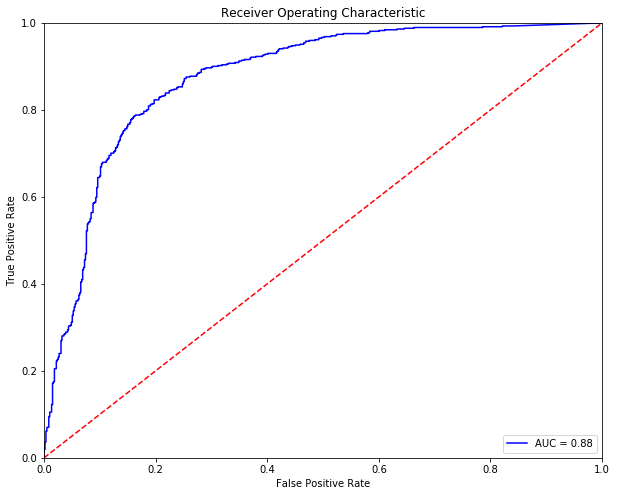

Optimal Threshold is 0.4867489433989628
Accuracy on test data is: 0.8101374570446735


Predicted  False  True  __all__
Actual                         
False        481   112      593
True         109   462      571
__all__      590   574     1164



Logistic Regression
Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.7,False,True,0.7,50,multinomial,l2,sag,0.001


Accuracy of the  Logistic  model for the training data is: 0.7841494845360825

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1845   472     2317
True         533  1806     2339
__all__     2378  2278     4656

Accuracy of the  Logistic  model for test data is: 0.802405498281787

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        484   109      593
True         121   450      571
__all__      605   559     1164

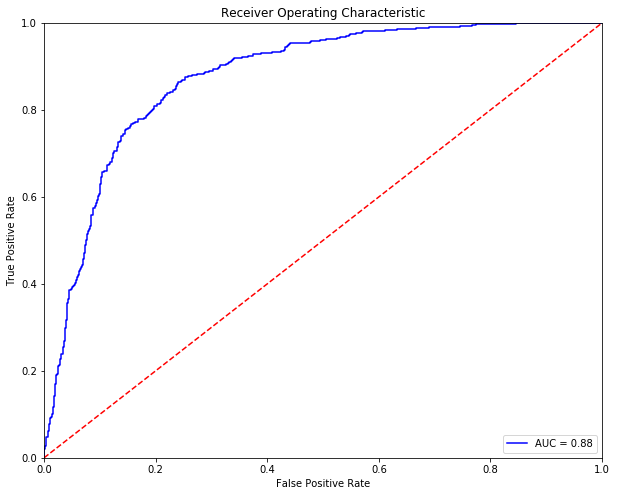

Optimal Threshold is 0.4897316494785526
Accuracy on test data is: 0.8032646048109966


Predicted  False  True  __all__
Actual                         
False        477   116      593
True         113   458      571
__all__      590   574     1164



RandomForest Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7929553264604811

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1689   628     2317
True         336  2003     2339
__all__     2025  2631     4656

Accuracy of the  Random Forest Trees  model for test data is: 0.8032646048109966

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        444   149      593
True          80   491      571
__all__      524   640     1164

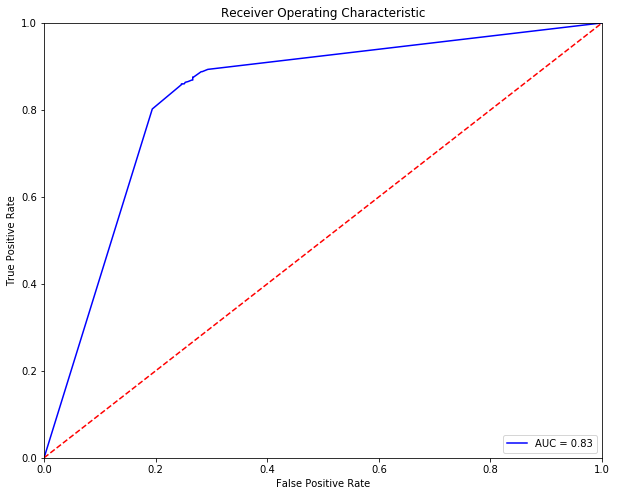

Optimal Threshold is 0.5556752319697215
Accuracy on test data is: 0.5094501718213058


Predicted   0.0  1.0  __all__
Actual                       
0.0         593    0      593
1.0         571    0      571
__all__    1164    0     1164

593
0
0
593
571
0
0
571
1.0
0.0
0.0
1.0


Adaoost Classifier
Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8043384879725086

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1758   559     2317
True         352  1987     2339
__all__     2110  2546     4656

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8067010309278351

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        456   137      593
True          88   483      571
__all__      544   620     1164

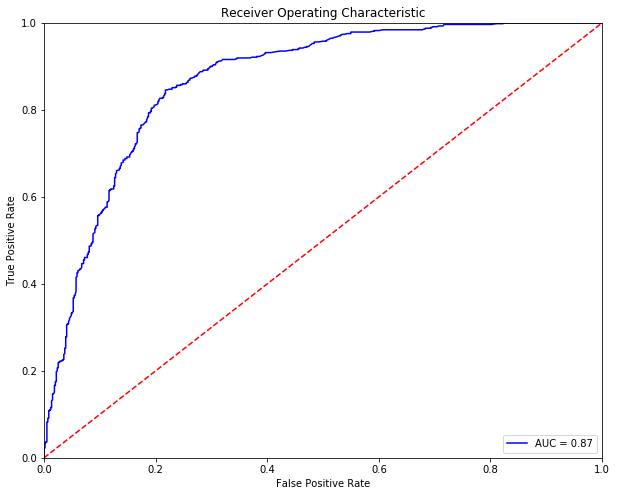

Optimal Threshold is 0.5089073109915986
Accuracy on test data is: 0.8058419243986255


Predicted  False  True  __all__
Actual                         
False        479   114      593
True         112   459      571
__all__      591   573     1164



GradientBoosting Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.03,deviance,20,0.1,150,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8105670103092784

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1803   514     2317
True         368  1971     2339
__all__     2171  2485     4656

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8144329896907216

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        467   126      593
True          90   481      571
__all__      557   607     1164

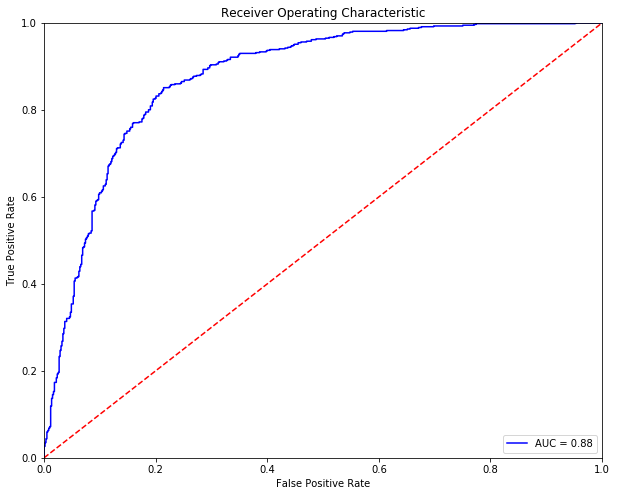

Optimal Threshold is 0.5811805352861916
Accuracy on test data is: 0.8084192439862543


Predicted  False  True  __all__
Actual                         
False        480   113      593
True         110   461      571
__all__      590   574     1164



ExtraTree Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,2,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8000429553264605

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1711   606     2317
True         325  2014     2339
__all__     2036  2620     4656

Accuracy of the  Extra Decision Tree  model for test data is: 0.7903780068728522

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        439   154      593
True          90   481      571
__all__      529   635     1164

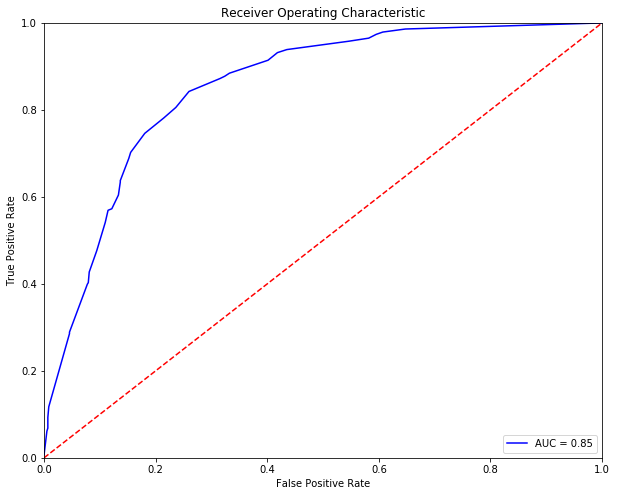

Optimal Threshold is 0.5802469135802469
Accuracy on test data is: 0.7835051546391752


Predicted  False  True  __all__
Actual                         
False        482   111      593
True         141   430      571
__all__      623   541     1164



Bagging Classifier
Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.3,200,True,0


Accuracy of the  Bagging  model for the training data is: 0.8969072164948454

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1987   330     2317
True         150  2189     2339
__all__     2137  2519     4656

Accuracy of the  Bagging  model for test data is: 0.8118556701030928

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        458   135      593
True          84   487      571
__all__      542   622     1164

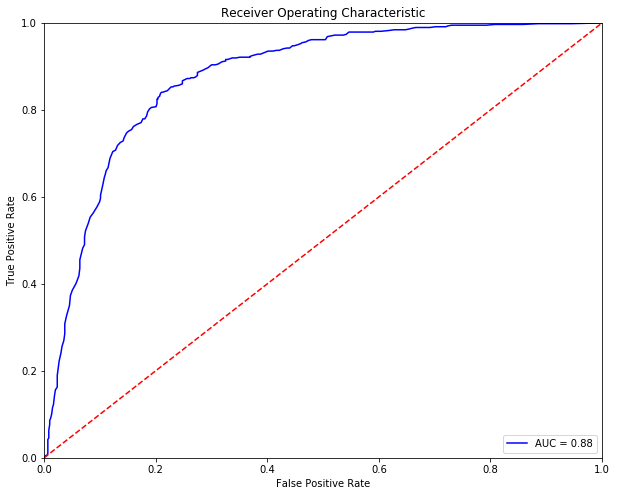

Optimal Threshold is 0.57
Accuracy on test data is: 0.8067010309278351


Predicted  False  True  __all__
Actual                         
False        480   113      593
True         112   459      571
__all__      592   572     1164



Neural Network-1
The accuracy of the model on training data is: 0.8344072164948454


Predicted  False  True  __all__
Actual                         
False       1715   602     2317
True         169  2170     2339
__all__     1884  2772     4656

The accuracy of the model on test data is: 0.7895189003436426


Predicted  False  True  __all__
Actual                         
False        424   169      593
True          76   495      571
__all__      500   664     1164

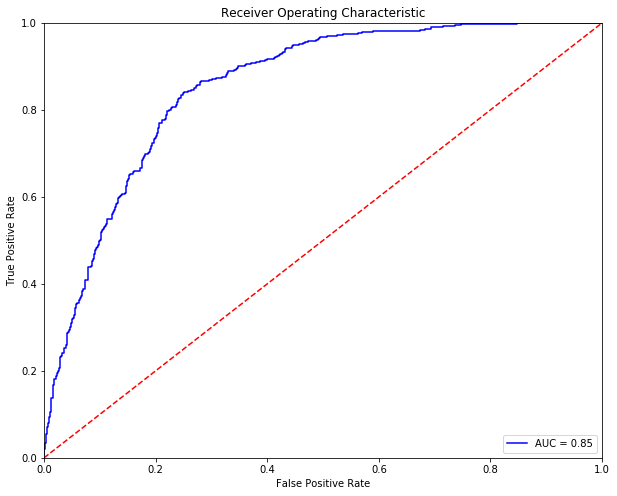

Optimal Threshold is 0.65138817
Accuracy of Logistic Model on training data is: 0.7809278350515464


Predicted  False  True  __all__
Actual                         
False        464   129      593
True         126   445      571
__all__      590   574     1164



Neural Network-2
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   57.7s finished


The accuracy of the model on training data is: 0.7968213058419243


Predicted  False  True  __all__
Actual                         
False       1779   538     2317
True         408  1931     2339
__all__     2187  2469     4656

The accuracy of the model on test data is: 0.8075601374570447


Predicted  False  True  __all__
Actual                         
False        465   128      593
True          96   475      571
__all__      561   603     1164

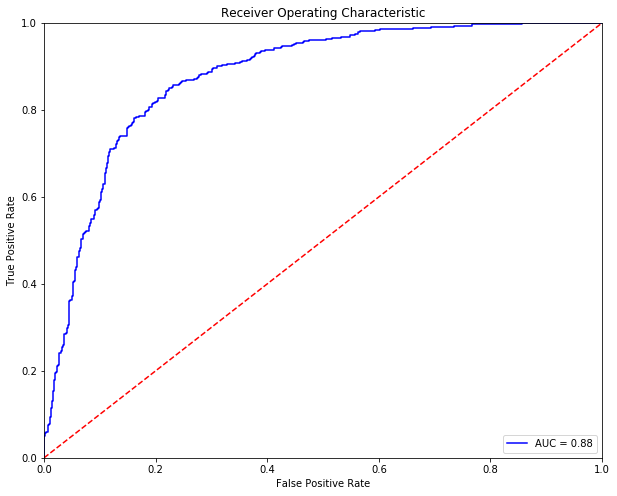

Optimal Threshold is 0.54306114
Accuracy on test data is: 0.8075601374570447


Predicted  False  True  __all__
Actual                         
False        479   114      593
True         110   461      571
__all__      589   575     1164

In [18]:
feat_imp=[None]*4
j=0
for i in range(0,9):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
    table_80_50_test_roc.loc[i]=([accuracy, cm.TP,  cm.TN,   cm.FP, cm.FN,  cm.FPR, cm.FNR, threshold,roc_auc])
    print("\n")

In [19]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns
table_80_50_test_roc['index']=ind_columns

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,2339.0,2317.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.784149,1806.0,1845.0,472.0,533.0,0.203712,0.227875
RandomForestClassifier,0.792955,2003.0,1689.0,628.0,336.0,0.271040,0.143651
AdaBoostClassifier,0.804338,1987.0,1758.0,559.0,352.0,0.241260,0.150492
GradientBoostingClassifier,0.810567,1971.0,1803.0,514.0,368.0,0.221839,0.157332
ExtraTreeClassifier,0.800043,2014.0,1711.0,606.0,325.0,0.261545,0.138948
BaggingClassifier,0.896907,2189.0,1987.0,330.0,150.0,0.142426,0.064130
Neural Network-1,0.834407,2170.0,1715.0,602.0,169.0,0.259819,0.072253
Neural-Network-2,0.796821,1931.0,1779.0,538.0,408.0,0.232197,0.174434


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.807560,455.0,485.0,108.0,116.0,0.182125,0.203152
LogisticRegression,0.802405,450.0,484.0,109.0,121.0,0.183811,0.211909
RandomForestClassifier,0.803265,491.0,444.0,149.0,80.0,0.251265,0.140105
AdaBoostClassifier,0.806701,483.0,456.0,137.0,88.0,0.231029,0.154116
GradientBoostingClassifier,0.814433,481.0,467.0,126.0,90.0,0.212479,0.157618
ExtraTreeClassifier,0.790378,481.0,439.0,154.0,90.0,0.259696,0.157618
BaggingClassifier,0.811856,487.0,458.0,135.0,84.0,0.227656,0.147110
Neural Network-1,0.789519,495.0,424.0,169.0,76.0,0.284992,0.133100
Neural-Network-2,0.807560,475.0,465.0,128.0,96.0,0.215852,0.168126


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.810137,462.000000,481.000000,112.000000,109.000000,0.188870,0.190893,0.486749,0.875745
LogisticRegression,0.803265,458.000000,477.000000,116.000000,113.000000,0.195616,0.197898,0.489732,0.876079
RandomForestClassifier,0.509450,302.103952,290.896048,290.896048,280.103952,0.509450,0.490550,0.555675,0.831375
AdaBoostClassifier,0.805842,459.000000,479.000000,114.000000,112.000000,0.192243,0.196147,0.508907,0.869377
GradientBoostingClassifier,0.808419,461.000000,480.000000,113.000000,110.000000,0.190556,0.192644,0.581181,0.877191
ExtraTreeClassifier,0.783505,430.000000,482.000000,111.000000,141.000000,0.187184,0.246935,0.580247,0.853127
BaggingClassifier,0.806701,459.000000,480.000000,113.000000,112.000000,0.190556,0.196147,0.570000,0.876524
Neural Network-1,0.780928,445.000000,464.000000,129.000000,126.000000,0.217538,0.220665,0.651388,0.853867
Neural-Network-2,0.807560,461.000000,479.000000,114.000000,110.000000,0.192243,0.192644,0.543061,0.877511


#### Random State 10

In [20]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('Feature_Vector_50_50_12_24_random_state_10.csv',index_col='User')


print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
# # Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(5))
Y=Y.values

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


1    2910
0    2910
Name: Target, dtype: int64

,SP,DP,NAPP,SIP,DIP,NREC,PAR,PAS,LEN,BYS,BYR,0000,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16414beb68334398f2f4d732aafedc2bf231b27b8507879ba41e0c18baec3847,4555,135,61,234,1180,5030,132.304771,73.091252,117.687475,16211.290656,162537.369185,505,537,405,191,123,63,55,31,60,58,68,140,306,137,125,191,109,234,264,244,361,205,399,219
910f8814c078483a86a1030fa3fce449aaeafd169b144fb3131f4c1577252cc3,9874,59,59,112,2319,11943,72.815373,68.967847,53.259315,33132.043708,73635.531525,226,124,250,322,544,1307,803,855,806,600,729,512,249,247,321,471,643,417,561,406,539,466,373,172


1 -> Infected
0 -> Uninfected


User
16414beb68334398f2f4d732aafedc2bf231b27b8507879ba41e0c18baec3847    1
910f8814c078483a86a1030fa3fce449aaeafd169b144fb3131f4c1577252cc3    1
117f95f1e1e2f68a2fcbb99523c4d6b2cd4307a559b566c799ea644cefadcf3b    0
4d648f5609b96f24133ff4ca6473d1bc6ae1e4d8723701c182c856b3eb4abebb    1
d225251f106c00909acb89ddc8766a8221b31e5d48cf3cd0d1dbbb877c47e30a    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.9376145588647304
The train/test split ratio is 80:20


In [21]:
## Table to store training and test measures
table_80_50_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

K-Nearest Neighbors
Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,30,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2302     0     2302
True           0  2354     2354
__all__     2302  2354     4656

Accuracy of the  KNN  model for test data is: 0.7852233676975945

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        473   135      608
True         115   441      556
__all__      588   576     1164

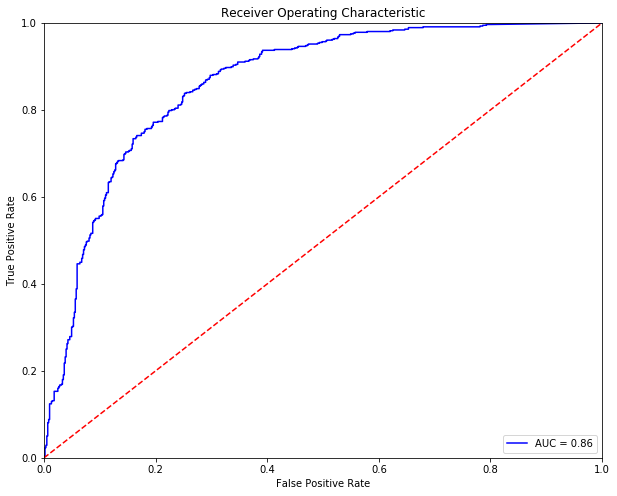

Optimal Threshold is 0.5138669282795044
Accuracy on test data is: 0.7852233676975945


Predicted  False  True  __all__
Actual                         
False        478   130      608
True         120   436      556
__all__      598   566     1164



Logistic Regression
Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.7,False,True,0.7,50,multinomial,l2,sag,0.001


Accuracy of the  Logistic  model for the training data is: 0.7961769759450171

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1848   454     2302
True         495  1859     2354
__all__     2343  2313     4656

Accuracy of the  Logistic  model for test data is: 0.7740549828178694

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        477   131      608
True         132   424      556
__all__      609   555     1164

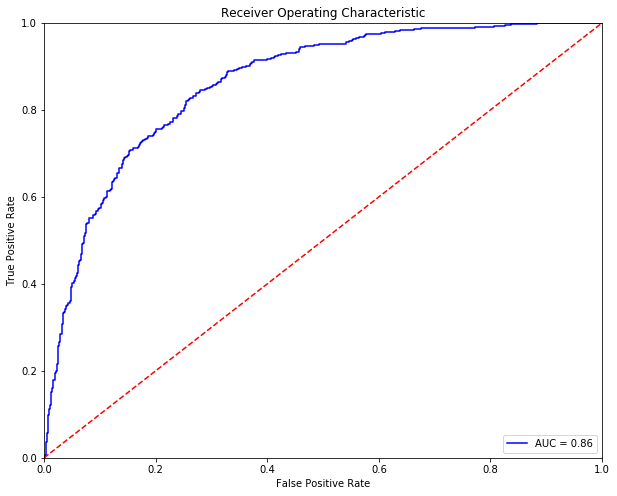

Optimal Threshold is 0.48943472101550456
Accuracy on test data is: 0.7714776632302406


Predicted  False  True  __all__
Actual                         
False        469   139      608
True         127   429      556
__all__      596   568     1164



RandomForest Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7998281786941581

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1664   638     2302
True         294  2060     2354
__all__     1958  2698     4656

Accuracy of the  Random Forest Trees  model for test data is: 0.781786941580756

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        433   175      608
True          79   477      556
__all__      512   652     1164

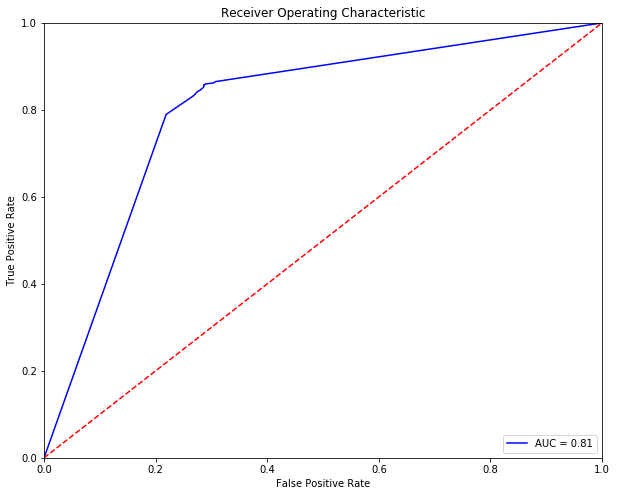

Optimal Threshold is 0.5600708893800384
Accuracy on test data is: 0.5223367697594502


Predicted   0.0  1.0  __all__
Actual                       
0.0         608    0      608
1.0         556    0      556
__all__    1164    0     1164

608
0
0
608
556
0
0
556
1.0
0.0
0.0
1.0


Adaoost Classifier
Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1.5,150,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8099226804123711

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1761   541     2302
True         344  2010     2354
__all__     2105  2551     4656

Accuracy of the  AdaBoostClassifier  model for test data is: 0.7878006872852233

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        449   159      608
True          88   468      556
__all__      537   627     1164

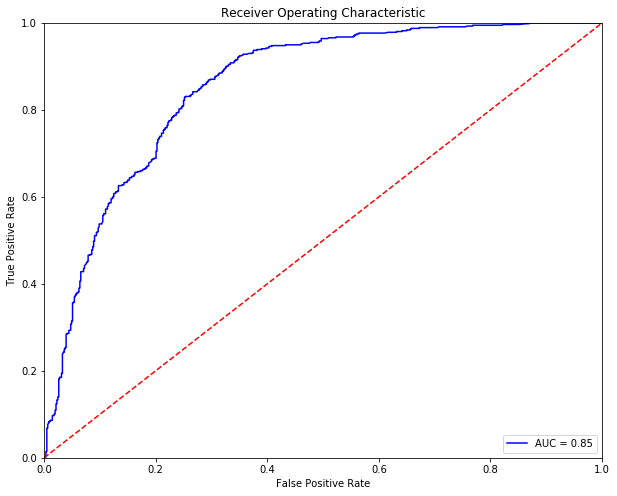

Optimal Threshold is 0.5013547325428175
Accuracy on test data is: 0.7749140893470791


Predicted  False  True  __all__
Actual                         
False        472   136      608
True         126   430      556
__all__      598   566     1164



GradientBoosting Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.2,deviance,10,0.3,50,0,0.5


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8101374570446735

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1775   527     2302
True         357  1997     2354
__all__     2132  2524     4656

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.7852233676975945

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        454   154      608
True          96   460      556
__all__      550   614     1164

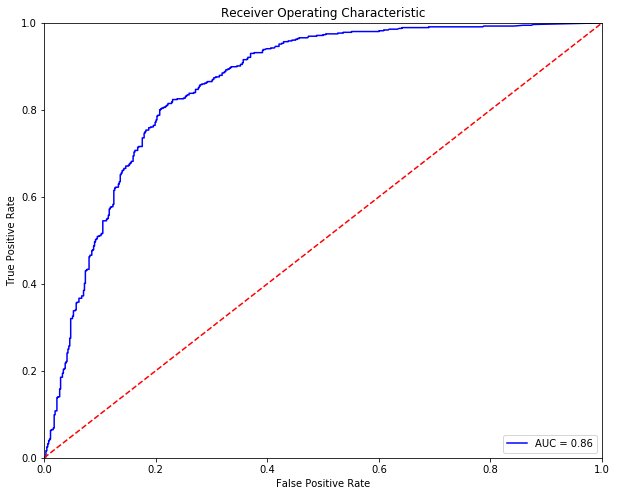

Optimal Threshold is 0.5951587328735359
Accuracy on test data is: 0.7912371134020618


Predicted  False  True  __all__
Actual                         
False        483   125      608
True         118   438      556
__all__      601   563     1164



ExtraTree Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,20,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8120704467353952

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1741   561     2302
True         314  2040     2354
__all__     2055  2601     4656

Accuracy of the  Extra Decision Tree  model for test data is: 0.7577319587628866

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        432   176      608
True         106   450      556
__all__      538   626     1164

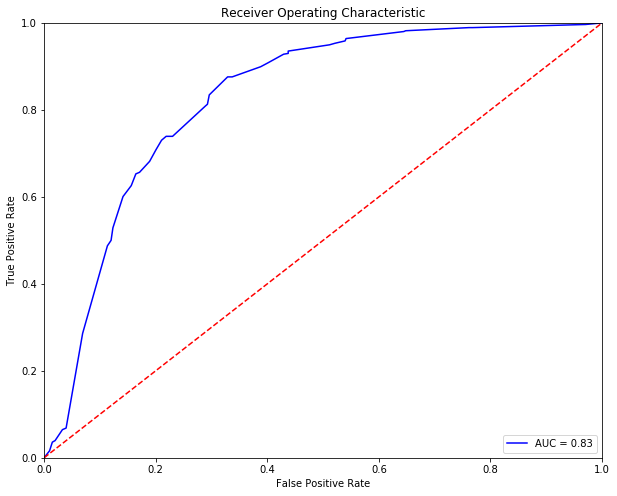

Optimal Threshold is 0.5263157894736842
Accuracy on test data is: 0.761168384879725


Predicted  False  True  __all__
Actual                         
False        475   133      608
True         145   411      556
__all__      620   544     1164



Bagging Classifier
Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.4,0.6,300,True,0


Accuracy of the  Bagging  model for the training data is: 0.9954896907216495

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2294     8     2302
True          13  2341     2354
__all__     2307  2349     4656

Accuracy of the  Bagging  model for test data is: 0.781786941580756

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        431   177      608
True          77   479      556
__all__      508   656     1164

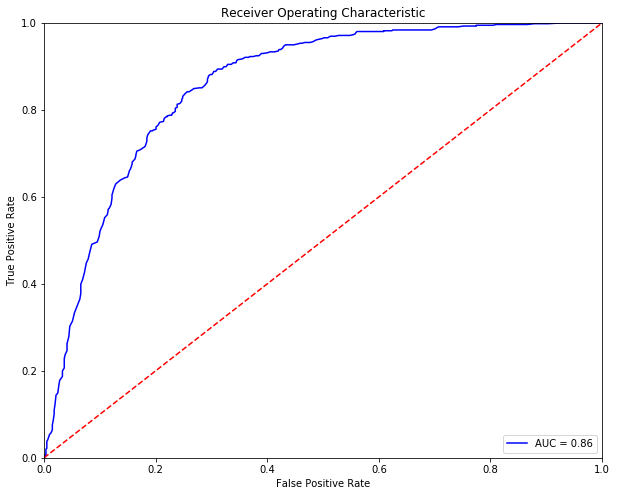

Optimal Threshold is 0.5933333333333334
Accuracy on test data is: 0.7826460481099656


Predicted  False  True  __all__
Actual                         
False        477   131      608
True         122   434      556
__all__      599   565     1164



Neural Network-1
The accuracy of the model on training data is: 0.8507302405498282


Predicted  False  True  __all__
Actual                         
False       1907   395     2302
True         300  2054     2354
__all__     2207  2449     4656

The accuracy of the model on test data is: 0.7766323024054983


Predicted  False  True  __all__
Actual                         
False        458   150      608
True         110   446      556
__all__      568   596     1164

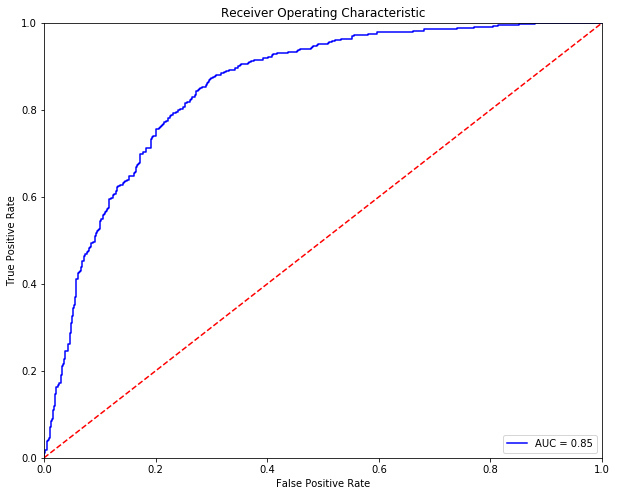

Optimal Threshold is 0.53383684
Accuracy of Logistic Model on training data is: 0.7783505154639175


Predicted  False  True  __all__
Actual                         
False        473   135      608
True         123   433      556
__all__      596   568     1164



Neural Network-2
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


The accuracy of the model on training data is: 0.7970360824742269


Predicted  False  True  __all__
Actual                         
False       1658   644     2302
True         301  2053     2354
__all__     1959  2697     4656

The accuracy of the model on test data is: 0.7800687285223368


Predicted  False  True  __all__
Actual                         
False        430   178      608
True          78   478      556
__all__      508   656     1164

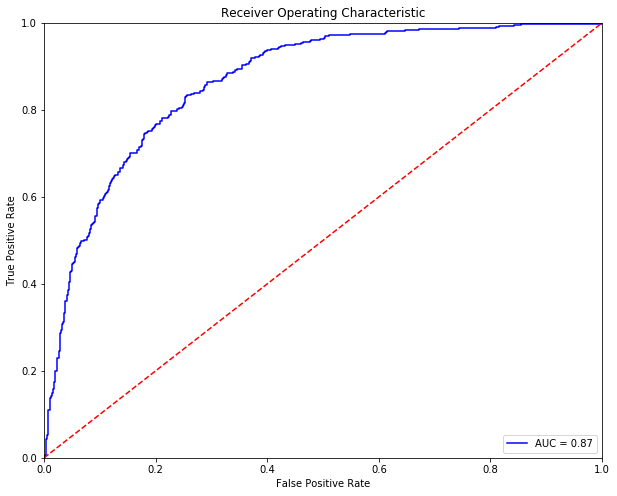

Optimal Threshold is 0.6697991
Accuracy on test data is: 0.7826460481099656


Predicted  False  True  __all__
Actual                         
False        477   131      608
True         122   434      556
__all__      599   565     1164

In [22]:
feat_imp_10=[None]*4
j=0
for i in range(0,9):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,feat_imp_10[j]=f[i](X_train,Y_train,X_test,Y_test)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_10_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_10_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
    table_80_50_10_test_roc.loc[i]=([accuracy, cm.TP,  cm.TN,   cm.FP, cm.FN,  cm.FPR, cm.FNR, threshold,roc_auc])
    print("\n")

In [23]:
table_80_50_10_train['index']=ind_columns
table_80_50_10_test['index']=ind_columns
table_80_50_10_test_roc['index']=ind_columns
table_80_50_10_test.set_index(['index'],drop=True,inplace=True)
table_80_50_10_train.set_index(['index'],drop=True,inplace=True)
table_80_50_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_10_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_10_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,2354.0,2302.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.796177,1859.0,1848.0,454.0,495.0,0.197220,0.210280
RandomForestClassifier,0.799828,2060.0,1664.0,638.0,294.0,0.277150,0.124894
AdaBoostClassifier,0.809923,2010.0,1761.0,541.0,344.0,0.235013,0.146134
GradientBoostingClassifier,0.810137,1997.0,1775.0,527.0,357.0,0.228931,0.151657
ExtraTreeClassifier,0.812070,2040.0,1741.0,561.0,314.0,0.243701,0.133390
BaggingClassifier,0.995490,2341.0,2294.0,8.0,13.0,0.003475,0.005523
Neural Network-1,0.850730,2054.0,1907.0,395.0,300.0,0.171590,0.127443
Neural-Network-2,0.797036,2053.0,1658.0,644.0,301.0,0.279757,0.127867


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.785223,441.0,473.0,135.0,115.0,0.222039,0.206835
LogisticRegression,0.774055,424.0,477.0,131.0,132.0,0.215461,0.237410
RandomForestClassifier,0.781787,477.0,433.0,175.0,79.0,0.287829,0.142086
AdaBoostClassifier,0.787801,468.0,449.0,159.0,88.0,0.261513,0.158273
GradientBoostingClassifier,0.785223,460.0,454.0,154.0,96.0,0.253289,0.172662
ExtraTreeClassifier,0.757732,450.0,432.0,176.0,106.0,0.289474,0.190647
BaggingClassifier,0.781787,479.0,431.0,177.0,77.0,0.291118,0.138489
Neural Network-1,0.776632,446.0,458.0,150.0,110.0,0.246711,0.197842
Neural-Network-2,0.780069,478.0,430.0,178.0,78.0,0.292763,0.140288


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.785223,436.000000,478.000000,130.000000,120.000000,0.213816,0.215827,0.513867,0.863132
LogisticRegression,0.771478,429.000000,469.000000,139.000000,127.000000,0.228618,0.228417,0.489435,0.860564
RandomForestClassifier,0.522337,317.580756,290.419244,290.419244,265.580756,0.522337,0.477663,0.560071,0.805779
AdaBoostClassifier,0.774914,430.000000,472.000000,136.000000,126.000000,0.223684,0.226619,0.501355,0.854864
GradientBoostingClassifier,0.791237,438.000000,483.000000,125.000000,118.000000,0.205592,0.212230,0.595159,0.858523
ExtraTreeClassifier,0.761168,411.000000,475.000000,133.000000,145.000000,0.218750,0.260791,0.526316,0.827252
BaggingClassifier,0.782646,434.000000,477.000000,131.000000,122.000000,0.215461,0.219424,0.593333,0.857466
Neural Network-1,0.778351,433.000000,473.000000,135.000000,123.000000,0.222039,0.221223,0.533837,0.852636
Neural-Network-2,0.782646,434.000000,477.000000,131.000000,122.000000,0.215461,0.219424,0.669799,0.865285


#### Random State 20

In [24]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('Feature_Vector_50_50_12_24_random_state_20.csv',index_col='User')


print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
# # Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(5))
Y=Y.values

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)


## Table to store training and test measures
table_80_50_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


1    2910
0    2910
Name: Target, dtype: int64

,SP,DP,NAPP,SIP,DIP,NREC,PAR,PAS,LEN,BYS,BYR,0000,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ba8eb5d1a8053b0997a90bea829c349d48200b46c815cec429a3f1a997c5ba98,994,23,34,106,305,1011,280.252226,164.641939,83.002967,13987.476756,359758.589515,0,0,0,0,0,0,0,0,1,2,58,80,103,68,62,111,155,226,100,12,15,6,8,4
f5448947a29087e5c7c74bcf1ef14257aaa6bad4990d3e9e976b79fa3511fa48,38,6,6,6,15,38,12.368421,10.394737,48.078947,1728.315789,9966.815789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,15,13,0,0,0,0,0,0,0


1 -> Infected
0 -> Uninfected


User
ba8eb5d1a8053b0997a90bea829c349d48200b46c815cec429a3f1a997c5ba98    0
f5448947a29087e5c7c74bcf1ef14257aaa6bad4990d3e9e976b79fa3511fa48    0
a70d401cfd6804c5711ae7620658b6be8b25483f999cb8bf73e44e011f877dd9    1
22730c54b8e7377fdfa932bf6b6c14741966f73ac8cc7d945fae9264c808afbb    0
47d304146c958a1134c7c928152e25972e4b8e660576183ae7dbca7d7db049db    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.9376584264360198
The train/test split ratio is 80:20


K-Nearest Neighbors
Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,30,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2357     0     2357
True           0  2299     2299
__all__     2357  2299     4656

Accuracy of the  KNN  model for test data is: 0.8067010309278351

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        441   112      553
True         113   498      611
__all__      554   610     1164

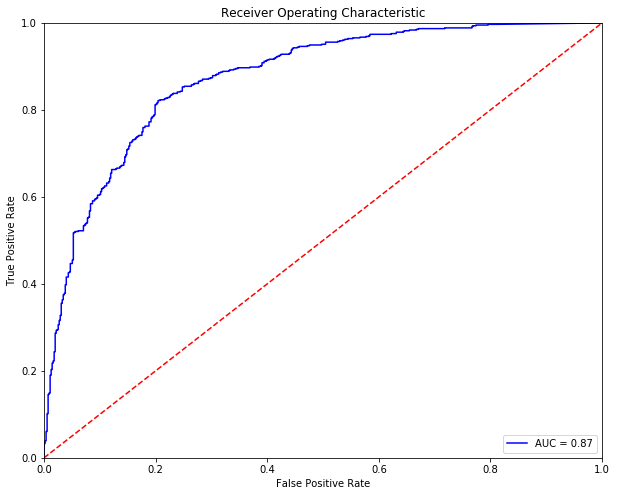

Optimal Threshold is 0.5041036962487141
Accuracy on test data is: 0.8058419243986255


Predicted  False  True  __all__
Actual                         
False        443   110      553
True         116   495      611
__all__      559   605     1164



Logistic Regression
Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.3,False,False,0.5,50,multinomial,l2,sag,1e-05


Accuracy of the  Logistic  model for the training data is: 0.7835051546391752

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1895   462     2357
True         546  1753     2299
__all__     2441  2215     4656

Accuracy of the  Logistic  model for test data is: 0.7972508591065293

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        460    93      553
True         143   468      611
__all__      603   561     1164

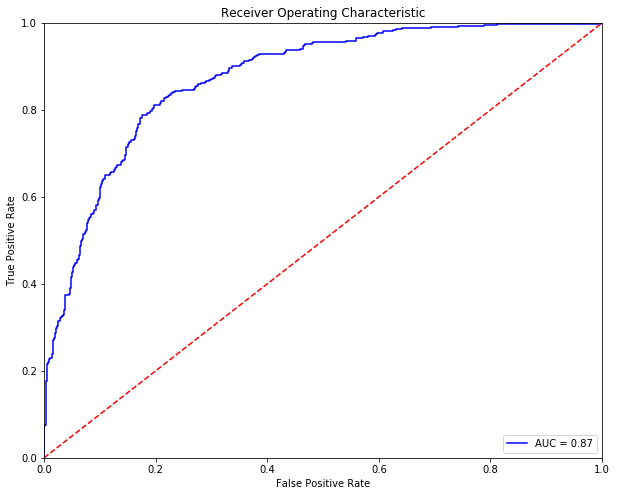

Optimal Threshold is 0.4694766091232793
Accuracy on test data is: 0.8041237113402062


Predicted  False  True  __all__
Actual                         
False        445   108      553
True         120   491      611
__all__      565   599     1164



RandomForest Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.789733676975945

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1709   648     2357
True         331  1968     2299
__all__     2040  2616     4656

Accuracy of the  Random Forest Trees  model for test data is: 0.8109965635738832

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        424   129      553
True          91   520      611
__all__      515   649     1164

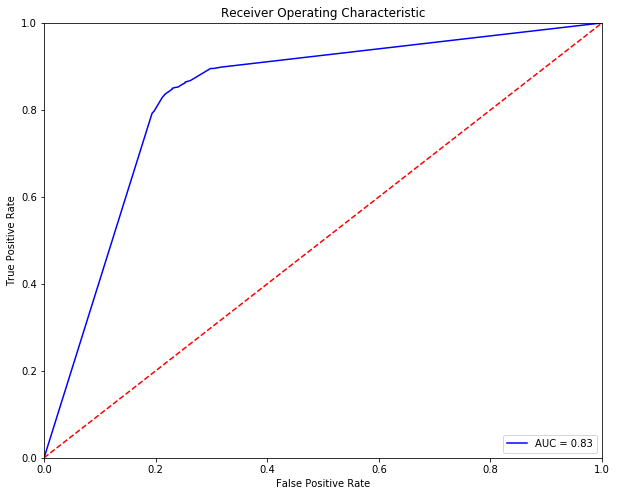

Optimal Threshold is 0.5447218125707719
Accuracy on test data is: 0.7989690721649485


Predicted  False  True  __all__
Actual                         
False        446   107      553
True         127   484      611
__all__      573   591     1164



Adaoost Classifier
Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME.R,0.5,50,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.7974656357388317

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1765   592     2357
True         351  1948     2299
__all__     2116  2540     4656

Accuracy of the  AdaBoostClassifier  model for test data is: 0.820446735395189

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        439   114      553
True          95   516      611
__all__      534   630     1164

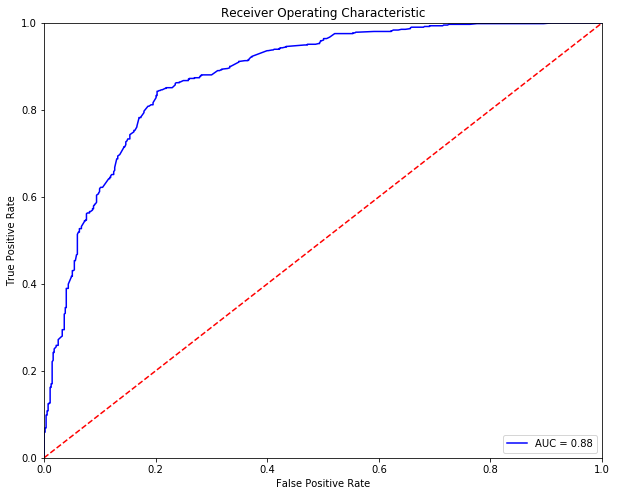

Optimal Threshold is 0.5032267717462324
Accuracy on test data is: 0.8109965635738832


Predicted  False  True  __all__
Actual                         
False        450   103      553
True         117   494      611
__all__      567   597     1164



GradientBoosting Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.05,deviance,10,0.2,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8118556701030928

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1831   526     2357
True         350  1949     2299
__all__     2181  2475     4656

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8161512027491409

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        443   110      553
True         104   507      611
__all__      547   617     1164

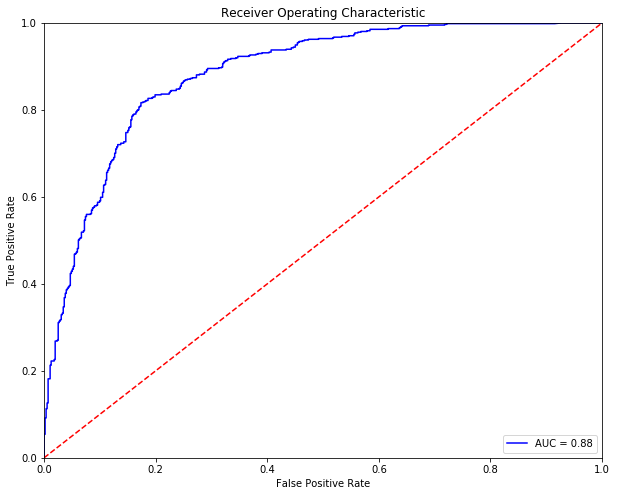

Optimal Threshold is 0.5259812728181922
Accuracy on test data is: 0.8187285223367697


Predicted  False  True  __all__
Actual                         
False        453   100      553
True         111   500      611
__all__      564   600     1164



ExtraTree Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,2,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.7976804123711341

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1766   591     2357
True         351  1948     2299
__all__     2117  2539     4656

Accuracy of the  Extra Decision Tree  model for test data is: 0.7920962199312714

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        411   142      553
True         100   511      611
__all__      511   653     1164

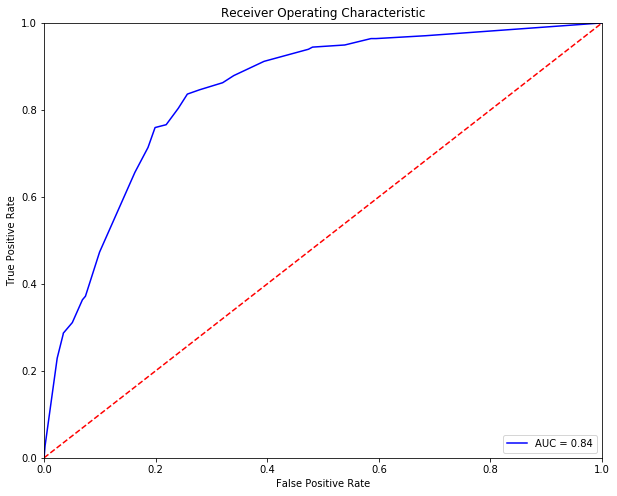

Optimal Threshold is 0.6274509803921569
Accuracy on test data is: 0.7792096219931272


Predicted  False  True  __all__
Actual                         
False        443   110      553
True         147   464      611
__all__      590   574     1164



Bagging Classifier
Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.4,0.3,200,True,0


Accuracy of the  Bagging  model for the training data is: 0.9091494845360825

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2069   288     2357
True         135  2164     2299
__all__     2204  2452     4656

Accuracy of the  Bagging  model for test data is: 0.7946735395189003

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        411   142      553
True          97   514      611
__all__      508   656     1164

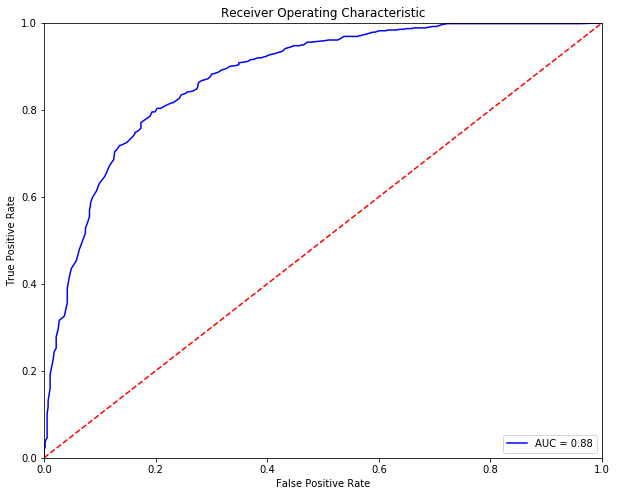

Optimal Threshold is 0.565
Accuracy on test data is: 0.8006872852233677


Predicted  False  True  __all__
Actual                         
False        446   107      553
True         125   486      611
__all__      571   593     1164



Neural Network-1
The accuracy of the model on training data is: 0.8466494845360825


Predicted  False  True  __all__
Actual                         
False       1896   461     2357
True         253  2046     2299
__all__     2149  2507     4656

The accuracy of the model on test data is: 0.8006872852233677


Predicted  False  True  __all__
Actual                         
False        415   138      553
True          94   517      611
__all__      509   655     1164

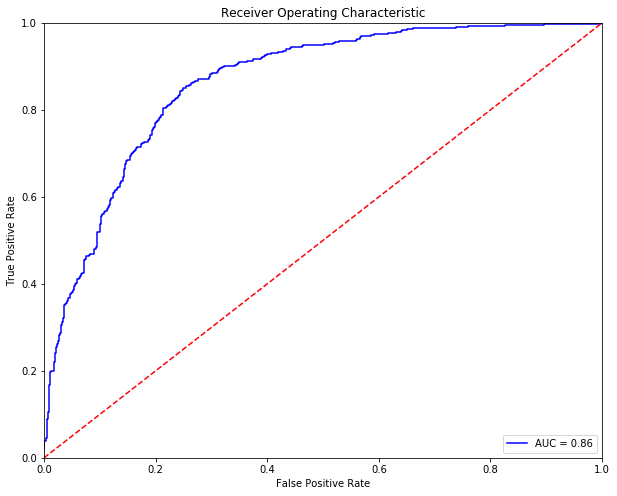

Optimal Threshold is 0.58529884
Accuracy of Logistic Model on training data is: 0.788659793814433


Predicted  False  True  __all__
Actual                         
False        437   116      553
True         130   481      611
__all__      567   597     1164



Neural Network-2
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


The accuracy of the model on training data is: 0.7888745704467354


Predicted  False  True  __all__
Actual                         
False       1606   751     2357
True         232  2067     2299
__all__     1838  2818     4656

The accuracy of the model on test data is: 0.7998281786941581


Predicted  False  True  __all__
Actual                         
False        388   165      553
True          68   543      611
__all__      456   708     1164

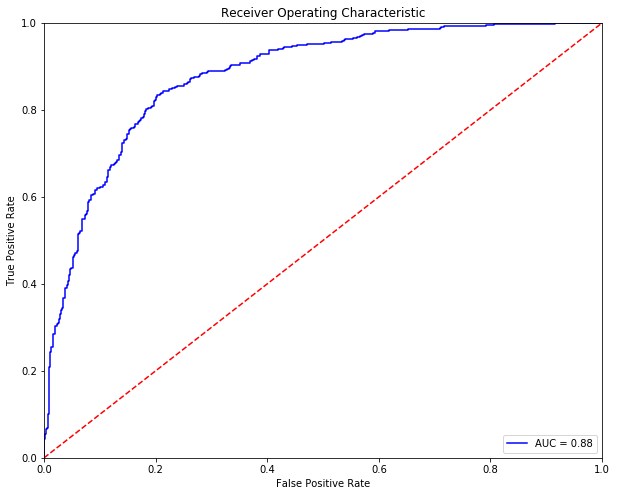

Optimal Threshold is 0.654523
Accuracy on test data is: 0.8075601374570447


Predicted  False  True  __all__
Actual                         
False        447   106      553
True         118   493      611
__all__      565   599     1164

In [25]:
feat_imp_20=[None]*4
j=0
for i in range(0,9):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,feat_imp_20[j]=f[i](X_train,Y_train,X_test,Y_test)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_20_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_20_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
    table_80_50_20_test_roc.loc[i]=([accuracy, cm.TP,  cm.TN,   cm.FP, cm.FN,  cm.FPR, cm.FNR, threshold,roc_auc])
    print("\n")

In [26]:
table_80_50_20_train['index']=ind_columns
table_80_50_20_test['index']=ind_columns
table_80_50_20_test_roc['index']=ind_columns
table_80_50_20_test.set_index(['index'],drop=True,inplace=True)
table_80_50_20_train.set_index(['index'],drop=True,inplace=True)
table_80_50_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_20_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_20_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,2299.0,2357.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.783505,1753.0,1895.0,462.0,546.0,0.196012,0.237495
RandomForestClassifier,0.789734,1968.0,1709.0,648.0,331.0,0.274926,0.143976
AdaBoostClassifier,0.797466,1948.0,1765.0,592.0,351.0,0.251167,0.152675
GradientBoostingClassifier,0.811856,1949.0,1831.0,526.0,350.0,0.223165,0.152240
ExtraTreeClassifier,0.797680,1948.0,1766.0,591.0,351.0,0.250742,0.152675
BaggingClassifier,0.909149,2164.0,2069.0,288.0,135.0,0.122189,0.058721
Neural Network-1,0.846649,2046.0,1896.0,461.0,253.0,0.195588,0.110048
Neural-Network-2,0.788875,2067.0,1606.0,751.0,232.0,0.318625,0.100913


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.806701,498.0,441.0,112.0,113.0,0.202532,0.184943
LogisticRegression,0.797251,468.0,460.0,93.0,143.0,0.168174,0.234043
RandomForestClassifier,0.810997,520.0,424.0,129.0,91.0,0.233273,0.148936
AdaBoostClassifier,0.820447,516.0,439.0,114.0,95.0,0.206148,0.155483
GradientBoostingClassifier,0.816151,507.0,443.0,110.0,104.0,0.198915,0.170213
ExtraTreeClassifier,0.792096,511.0,411.0,142.0,100.0,0.256781,0.163666
BaggingClassifier,0.794674,514.0,411.0,142.0,97.0,0.256781,0.158756
Neural Network-1,0.800687,517.0,415.0,138.0,94.0,0.249548,0.153846
Neural-Network-2,0.799828,543.0,388.0,165.0,68.0,0.298373,0.111293


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.805842,495.0,443.0,110.0,116.0,0.198915,0.189853,0.504104,0.872536
LogisticRegression,0.804124,491.0,445.0,108.0,120.0,0.195298,0.196399,0.469477,0.874039
RandomForestClassifier,0.798969,484.0,446.0,107.0,127.0,0.193490,0.207856,0.544722,0.831217
AdaBoostClassifier,0.810997,494.0,450.0,103.0,117.0,0.186257,0.191489,0.503227,0.879899
GradientBoostingClassifier,0.818729,500.0,453.0,100.0,111.0,0.180832,0.181669,0.525981,0.883562
ExtraTreeClassifier,0.779210,464.0,443.0,110.0,147.0,0.198915,0.240589,0.627451,0.842061
BaggingClassifier,0.800687,486.0,446.0,107.0,125.0,0.193490,0.204583,0.565000,0.875985
Neural Network-1,0.788660,481.0,437.0,116.0,130.0,0.209765,0.212766,0.585299,0.862556
Neural-Network-2,0.807560,493.0,447.0,106.0,118.0,0.191682,0.193126,0.654523,0.879763


In [28]:
table_80_50_train_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_80_50_test_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_80_50_test_roc_avg=pd.DataFrame(columns=['accuracy','FPR','FNR','auc'])

table_80_50_train_avg['accuracy']=(table_80_50_train['accuracy']+table_80_50_10_train['accuracy']+table_80_50_20_train['accuracy'])/3.0
table_80_50_train_avg['FPR']=(table_80_50_train['FPR']+table_80_50_10_train['FPR']+table_80_50_20_train['FPR'])/3.0
table_80_50_train_avg['FNR']=(table_80_50_train['FNR']+table_80_50_10_train['FNR']+table_80_50_20_train['FNR'])/3.0

table_80_50_test_avg['accuracy']=(table_80_50_test['accuracy']+table_80_50_10_test['accuracy']+table_80_50_20_test['accuracy'])/3.0
table_80_50_test_avg['FPR']=(table_80_50_test['FPR']+table_80_50_10_test['FPR']+table_80_50_20_test['FPR'])/3.0
table_80_50_test_avg['FNR']=(table_80_50_test['FNR']+table_80_50_10_test['FNR']+table_80_50_20_test['FNR'])/3.0

table_80_50_test_roc_avg['accuracy']=(table_80_50_test_roc['accuracy']+table_80_50_10_test_roc['accuracy']+table_80_50_20_test_roc['accuracy'])/3.0
table_80_50_test_roc_avg['FPR']=(table_80_50_test_roc['FPR']+table_80_50_10_test_roc['FPR']+table_80_50_20_test_roc['FPR'])/3.0
table_80_50_test_roc_avg['FNR']=(table_80_50_test_roc['FNR']+table_80_50_10_test_roc['FNR']+table_80_50_20_test_roc['FNR'])/3.0
table_80_50_test_roc_avg['auc']=(table_80_50_test_roc['auc']+table_80_50_10_test_roc['auc']+table_80_50_20_test_roc['auc'])/3.0


print("-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------")
print("Comparision Table for Training Accuracies:")
display(table_80_50_train_avg)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test_avg)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc_avg)


feat_imp_80_50=list(map(sum, zip(feat_imp,feat_imp_10,feat_imp_20)))
print("Average feature imortance for the 3 random sets:")
feat_impt_plot(sum(feat_imp_80_50)/12)

-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------
Comparision Table for Training Accuracies:


,accuracy,FPR,FNR
index,,,
KNeighborsClassifier,1.000000,0.000000,0.000000
LogisticRegression,0.787944,0.198981,0.225217
RandomForestClassifier,0.794172,0.274372,0.137507
AdaBoostClassifier,0.803909,0.242480,0.149767
GradientBoostingClassifier,0.810853,0.224645,0.153743
ExtraTreeClassifier,0.803265,0.251996,0.141671
BaggingClassifier,0.933849,0.089363,0.042791
Neural Network-1,0.843929,0.208999,0.103248
Neural-Network-2,0.794244,0.276860,0.134405


Comparision Table for Test Accuracies:


,accuracy,FPR,FNR
index,,,
KNeighborsClassifier,0.799828,0.202232,0.198310
LogisticRegression,0.791237,0.189148,0.227787
RandomForestClassifier,0.798683,0.257456,0.143709
AdaBoostClassifier,0.804983,0.232897,0.155957
GradientBoostingClassifier,0.805269,0.221561,0.166831
ExtraTreeClassifier,0.780069,0.268650,0.170644
BaggingClassifier,0.796105,0.258519,0.148119
Neural Network-1,0.788946,0.260417,0.161596
Neural-Network-2,0.795819,0.268996,0.139902


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,FPR,FNR,auc
index,,,,
KNeighborsClassifier,0.800401,0.200534,0.198858,0.870471
LogisticRegression,0.792955,0.206511,0.207572,0.870227
RandomForestClassifier,0.610252,0.408426,0.392023,0.822790
AdaBoostClassifier,0.797251,0.200728,0.204752,0.868047
GradientBoostingClassifier,0.806128,0.192327,0.195515,0.873092
ExtraTreeClassifier,0.774628,0.201616,0.249439,0.840813
BaggingClassifier,0.796678,0.199836,0.206718,0.869991
Neural Network-1,0.782646,0.216447,0.218218,0.856353
Neural-Network-2,0.799255,0.199795,0.201732,0.874187


Average feature imortance for the 3 random sets:


###  <a id='1.B' style="text-decoration : none; color : #000000;">B. 70:30 Train Test Split</a>
#### Random State 0

In [29]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('Feature_Vector_50_50_12_24_random_state_0.csv',index_col='User')


print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
# # Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(5))
Y=Y.values

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)


## Table to store training and test measures
table_70_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


1    2910
0    2910
Name: Target, dtype: int64

,SP,DP,NAPP,SIP,DIP,NREC,PAR,PAS,LEN,BYS,BYR,0000,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
acbc3e760a890f55ceafd2573cde6f7c040dae93259a0cdfc7d1338dd60c6953,6855,69,70,102,1503,7494,182.050440,70.107419,109.414331,18672.453563,223011.614091,319,339,265,588,981,782,183,139,87,167,70,122,149,313,268,399,825,309,223,264,229,125,126,222
3c45372db59b842faec38488806b64c282270417f6755ba493e51eda8e98b402,13,4,4,3,8,13,97.769231,90.000000,88.461538,7757.153846,120738.153846,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,1,7,0,0,0,0,0,0,0


1 -> Infected
0 -> Uninfected


User
acbc3e760a890f55ceafd2573cde6f7c040dae93259a0cdfc7d1338dd60c6953    1
3c45372db59b842faec38488806b64c282270417f6755ba493e51eda8e98b402    0
653fe3e24024826e008a512560be7abb15b06bd46e89ba4159dbdc6b8b5983c3    0
8c8d63c29001941282625da51ded54c9305c2b2c5ed680ef803b61b1231a2107    1
ac87be58a25e50356ef8d66135f93392ac6c40f3c7b557e7c16f663ce168e9fc    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.9392012639691998
The train/test split ratio is 70:30


K-Nearest Neighbors
Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,50,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2028     0     2028
True           0  2046     2046
__all__     2028  2046     4074

Accuracy of the  KNN  model for test data is: 0.8098510882016037

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        732   150      882
True         182   682      864
__all__      914   832     1746

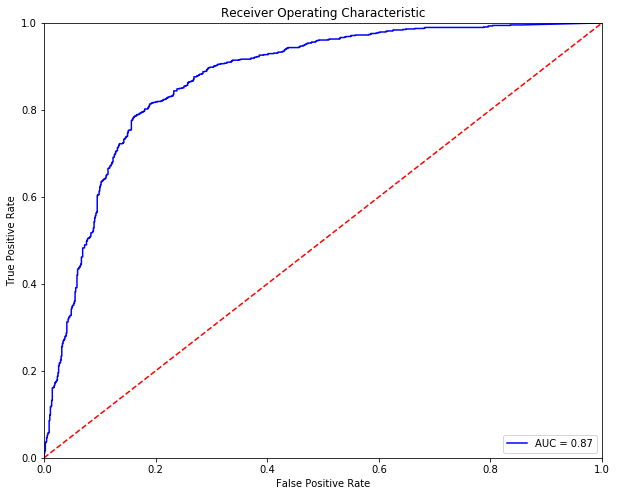

Optimal Threshold is 0.4721578173753999
Accuracy on test data is: 0.8109965635738832


Predicted  False  True  __all__
Actual                         
False        716   166      882
True         164   700      864
__all__      880   866     1746



Logistic Regression
Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.3,False,True,0.5,100,multinomial,l2,sag,0.1


Accuracy of the  Logistic  model for the training data is: 0.7810505645557192

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1593   435     2028
True         457  1589     2046
__all__     2050  2024     4074

Accuracy of the  Logistic  model for test data is: 0.7938144329896907

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        709   173      882
True         187   677      864
__all__      896   850     1746

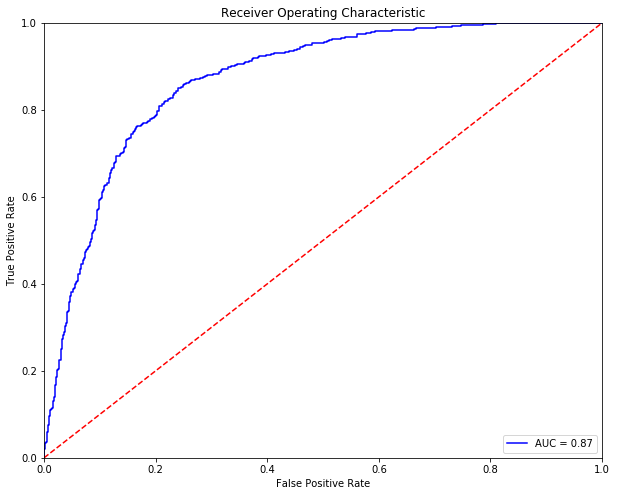

Optimal Threshold is 0.49109394690179486
Accuracy on test data is: 0.7966781214203894


Predicted  False  True  __all__
Actual                         
False        703   179      882
True         176   688      864
__all__      879   867     1746



RandomForest Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,300,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7896416298478154

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1448   580     2028
True         277  1769     2046
__all__     1725  2349     4074

Accuracy of the  Random Forest Trees  model for test data is: 0.800114547537228

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        644   238      882
True         111   753      864
__all__      755   991     1746

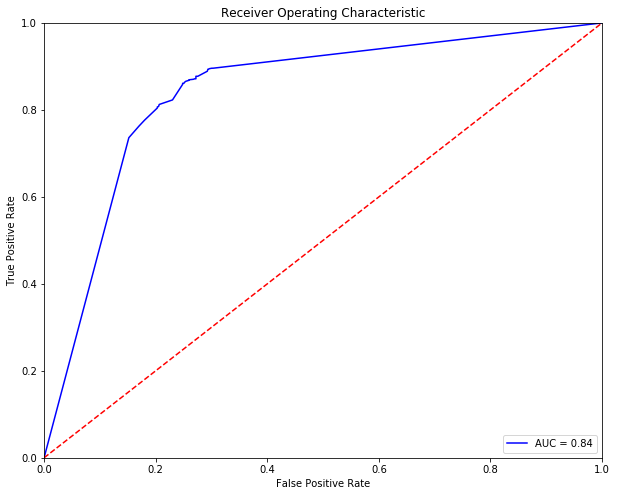

Optimal Threshold is 0.5504912946381939
Accuracy on test data is: 0.7983963344788088


Predicted  False  True  __all__
Actual                         
False        723   159      882
True         193   671      864
__all__      916   830     1746



Adaoost Classifier
Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1.5,50,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8009327442317133

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1540   488     2028
True         323  1723     2046
__all__     1863  2211     4074

Accuracy of the  AdaBoostClassifier  model for test data is: 0.7989690721649485

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        669   213      882
True         138   726      864
__all__      807   939     1746

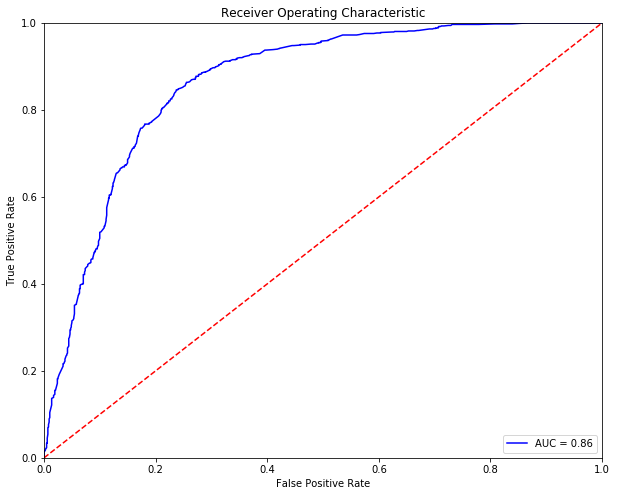

Optimal Threshold is 0.5009541791728879
Accuracy on test data is: 0.7903780068728522


Predicted  False  True  __all__
Actual                         
False        701   181      882
True         185   679      864
__all__      886   860     1746



GradientBoosting Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.05,deviance,20,0.1,100,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8124693176239568

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1576   452     2028
True         312  1734     2046
__all__     1888  2186     4074

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8075601374570447

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        680   202      882
True         134   730      864
__all__      814   932     1746

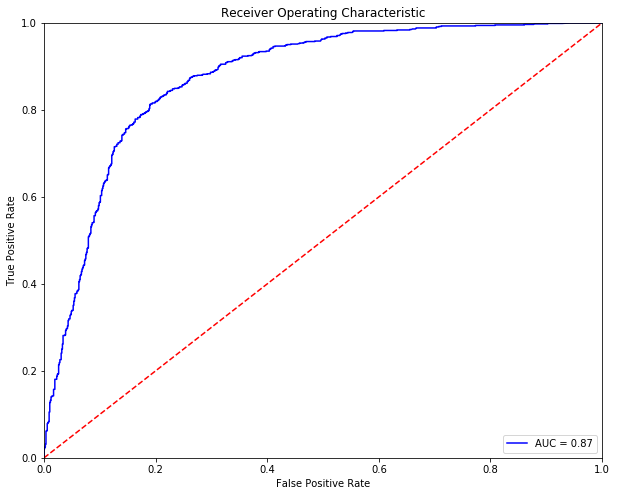

Optimal Threshold is 0.5708640042885383
Accuracy on test data is: 0.8104238258877434


Predicted  False  True  __all__
Actual                         
False        715   167      882
True         164   700      864
__all__      879   867     1746



ExtraTree Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,20,auto,0.001,2,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.7974963181148749

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1540   488     2028
True         337  1709     2046
__all__     1877  2197     4074

Accuracy of the  Extra Decision Tree  model for test data is: 0.7829324169530355

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        657   225      882
True         154   710      864
__all__      811   935     1746

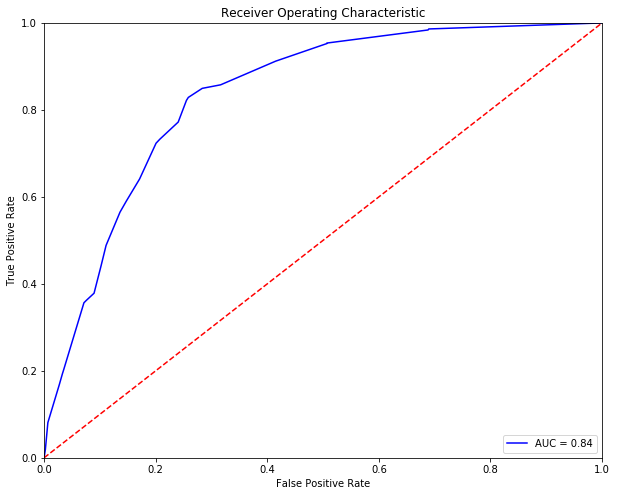

Optimal Threshold is 0.5958904109589042
Accuracy on test data is: 0.7628865979381443


Predicted  False  True  __all__
Actual                         
False        699   183      882
True         231   633      864
__all__      930   816     1746



Bagging Classifier
Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.6,200,True,0


Accuracy of the  Bagging  model for the training data is: 0.9921453117329406

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2017    11     2028
True          21  2025     2046
__all__     2038  2036     4074

Accuracy of the  Bagging  model for test data is: 0.800114547537228

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        667   215      882
True         134   730      864
__all__      801   945     1746

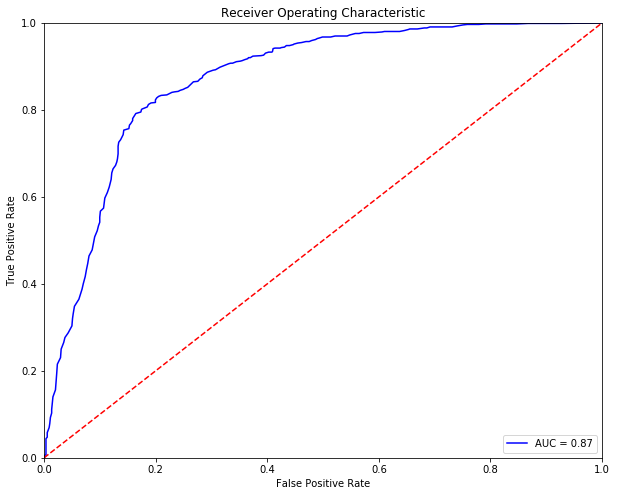

Optimal Threshold is 0.565
Accuracy on test data is: 0.8109965635738832


Predicted  False  True  __all__
Actual                         
False        719   163      882
True         167   697      864
__all__      886   860     1746



Neural Network-1
The accuracy of the model on training data is: 0.8463426607756505


Predicted  False  True  __all__
Actual                         
False       1597   431     2028
True         195  1851     2046
__all__     1792  2282     4074

The accuracy of the model on test data is: 0.7726231386025201


Predicted  False  True  __all__
Actual                         
False        631   251      882
True         146   718      864
__all__      777   969     1746

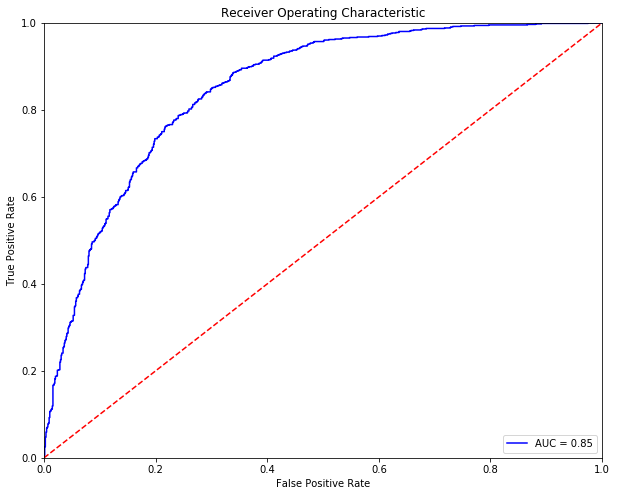

Optimal Threshold is 0.6020086
Accuracy of Logistic Model on training data is: 0.7697594501718213


Predicted  False  True  __all__
Actual                         
False        679   203      882
True         199   665      864
__all__      878   868     1746



Neural Network-2
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.9min finished


The accuracy of the model on training data is: 0.7955326460481099


Predicted  False  True  __all__
Actual                         
False       1539   489     2028
True         344  1702     2046
__all__     1883  2191     4074

The accuracy of the model on test data is: 0.806987399770905


Predicted  False  True  __all__
Actual                         
False        680   202      882
True         135   729      864
__all__      815   931     1746

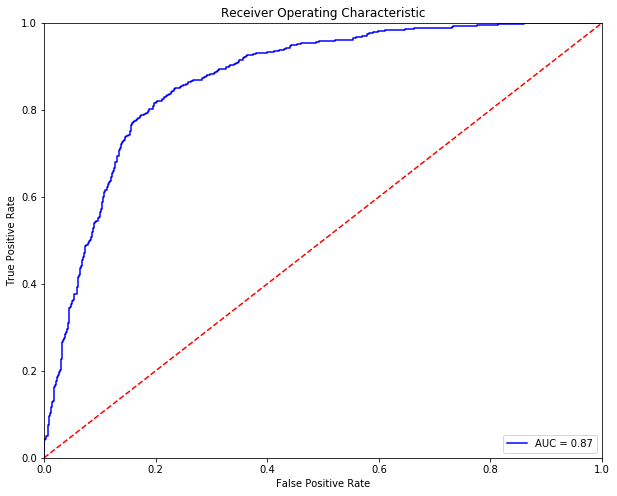

Optimal Threshold is 0.5903182
Accuracy on test data is: 0.8064146620847652


Predicted  False  True  __all__
Actual                         
False        710   172      882
True         166   698      864
__all__      876   870     1746

In [30]:
feat_imp=[None]*4
j=0
for i in range(0,9):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_70_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_70_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
    table_70_50_test_roc.loc[i]=([accuracy, cm.TP,  cm.TN,   cm.FP, cm.FN,  cm.FPR, cm.FNR, threshold,roc_auc])
    print("\n")

In [31]:
table_70_50_train['index']=ind_columns
table_70_50_test['index']=ind_columns
table_70_50_test_roc['index']=ind_columns

table_70_50_test.set_index(['index'],drop=True,inplace=True)
table_70_50_train.set_index(['index'],drop=True,inplace=True)
table_70_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,2046.0,2028.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.781051,1589.0,1593.0,435.0,457.0,0.214497,0.223363
RandomForestClassifier,0.789642,1769.0,1448.0,580.0,277.0,0.285996,0.135386
AdaBoostClassifier,0.800933,1723.0,1540.0,488.0,323.0,0.240631,0.157869
GradientBoostingClassifier,0.812469,1734.0,1576.0,452.0,312.0,0.222880,0.152493
ExtraTreeClassifier,0.797496,1709.0,1540.0,488.0,337.0,0.240631,0.164712
BaggingClassifier,0.992145,2025.0,2017.0,11.0,21.0,0.005424,0.010264
Neural Network-1,0.846343,1851.0,1597.0,431.0,195.0,0.212525,0.095308
Neural-Network-2,0.795533,1702.0,1539.0,489.0,344.0,0.241124,0.168133


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.809851,682.0,732.0,150.0,182.0,0.170068,0.210648
LogisticRegression,0.793814,677.0,709.0,173.0,187.0,0.196145,0.216435
RandomForestClassifier,0.800115,753.0,644.0,238.0,111.0,0.269841,0.128472
AdaBoostClassifier,0.798969,726.0,669.0,213.0,138.0,0.241497,0.159722
GradientBoostingClassifier,0.807560,730.0,680.0,202.0,134.0,0.229025,0.155093
ExtraTreeClassifier,0.782932,710.0,657.0,225.0,154.0,0.255102,0.178241
BaggingClassifier,0.800115,730.0,667.0,215.0,134.0,0.243764,0.155093
Neural Network-1,0.772623,718.0,631.0,251.0,146.0,0.284580,0.168981
Neural-Network-2,0.806987,729.0,680.0,202.0,135.0,0.229025,0.156250


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.810997,700.0,716.0,166.0,164.0,0.188209,0.189815,0.472158,0.872742
LogisticRegression,0.796678,688.0,703.0,179.0,176.0,0.202948,0.203704,0.491094,0.869157
RandomForestClassifier,0.798396,671.0,723.0,159.0,193.0,0.180272,0.223380,0.550491,0.841517
AdaBoostClassifier,0.790378,679.0,701.0,181.0,185.0,0.205215,0.214120,0.500954,0.863557
GradientBoostingClassifier,0.810424,700.0,715.0,167.0,164.0,0.189342,0.189815,0.570864,0.874855
ExtraTreeClassifier,0.762887,633.0,699.0,183.0,231.0,0.207483,0.267361,0.595890,0.836340
BaggingClassifier,0.810997,697.0,719.0,163.0,167.0,0.184807,0.193287,0.565000,0.870372
Neural Network-1,0.769759,665.0,679.0,203.0,199.0,0.230159,0.230324,0.602009,0.848279
Neural-Network-2,0.806415,698.0,710.0,172.0,166.0,0.195011,0.192130,0.590318,0.870646


#### Random State 10

In [32]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('Feature_Vector_50_50_12_24_random_state_10.csv',index_col='User')


print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
# # Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(5))
Y=Y.values

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

## Table to store training and test measures
table_70_50_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


1    2910
0    2910
Name: Target, dtype: int64

,SP,DP,NAPP,SIP,DIP,NREC,PAR,PAS,LEN,BYS,BYR,0000,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16414beb68334398f2f4d732aafedc2bf231b27b8507879ba41e0c18baec3847,4555,135,61,234,1180,5030,132.304771,73.091252,117.687475,16211.290656,162537.369185,505,537,405,191,123,63,55,31,60,58,68,140,306,137,125,191,109,234,264,244,361,205,399,219
910f8814c078483a86a1030fa3fce449aaeafd169b144fb3131f4c1577252cc3,9874,59,59,112,2319,11943,72.815373,68.967847,53.259315,33132.043708,73635.531525,226,124,250,322,544,1307,803,855,806,600,729,512,249,247,321,471,643,417,561,406,539,466,373,172


1 -> Infected
0 -> Uninfected


User
16414beb68334398f2f4d732aafedc2bf231b27b8507879ba41e0c18baec3847    1
910f8814c078483a86a1030fa3fce449aaeafd169b144fb3131f4c1577252cc3    1
117f95f1e1e2f68a2fcbb99523c4d6b2cd4307a559b566c799ea644cefadcf3b    0
4d648f5609b96f24133ff4ca6473d1bc6ae1e4d8723701c182c856b3eb4abebb    1
d225251f106c00909acb89ddc8766a8221b31e5d48cf3cd0d1dbbb877c47e30a    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.9376145588647304
The train/test split ratio is 70:30


K-Nearest Neighbors
Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,50,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2013     0     2013
True           0  2061     2061
__all__     2013  2061     4074

Accuracy of the  KNN  model for test data is: 0.7915234822451317

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        722   175      897
True         189   660      849
__all__      911   835     1746

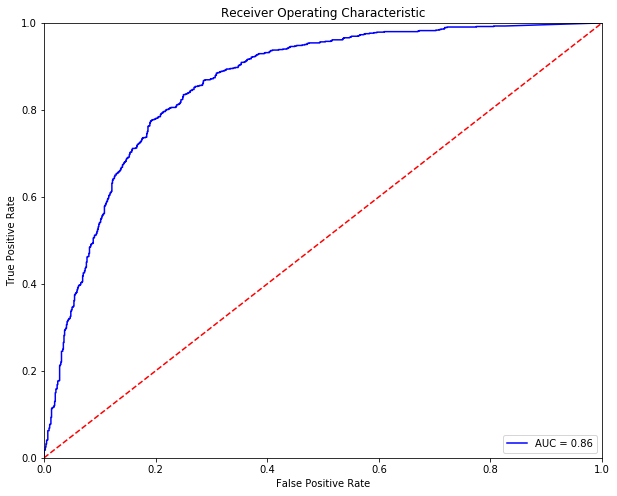

Optimal Threshold is 0.46844411386463164
Accuracy on test data is: 0.7903780068728522


Predicted  False  True  __all__
Actual                         
False        709   188      897
True         178   671      849
__all__      887   859     1746



Logistic Regression
Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,50,ovr,l2,sag,1e-05


Accuracy of the  Logistic  model for the training data is: 0.7955326460481099

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1611   402     2013
True         431  1630     2061
__all__     2042  2032     4074

Accuracy of the  Logistic  model for test data is: 0.7789232531500573

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        716   181      897
True         205   644      849
__all__      921   825     1746

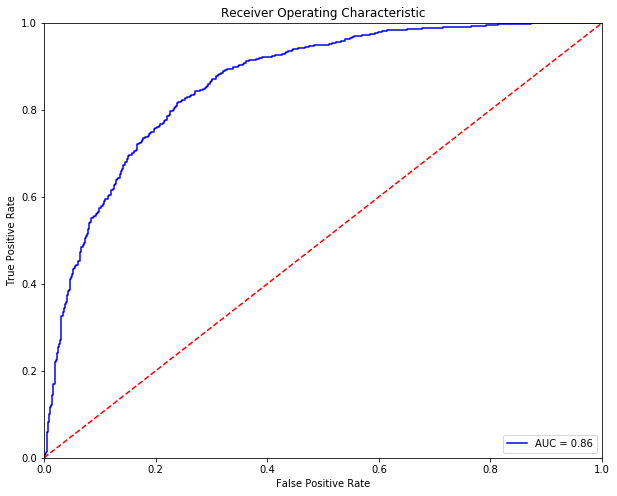

Optimal Threshold is 0.4595381051930982
Accuracy on test data is: 0.779495990836197


Predicted  False  True  __all__
Actual                         
False        700   197      897
True         188   661      849
__all__      888   858     1746



RandomForest Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,300,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7997054491899853

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1451   562     2013
True         254  1807     2061
__all__     1705  2369     4074

Accuracy of the  Random Forest Trees  model for test data is: 0.7875143184421535

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        652   245      897
True         126   723      849
__all__      778   968     1746

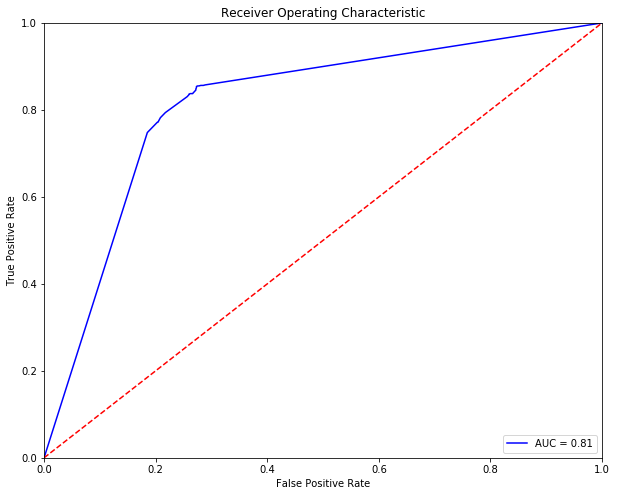

Optimal Threshold is 0.5511467893730332
Accuracy on test data is: 0.784077892325315


Predicted  False  True  __all__
Actual                         
False        714   183      897
True         194   655      849
__all__      908   838     1746



Adaoost Classifier
Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,0.5,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8063328424153167

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1502   511     2013
True         278  1783     2061
__all__     1780  2294     4074

Accuracy of the  AdaBoostClassifier  model for test data is: 0.7983963344788088

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        682   215      897
True         137   712      849
__all__      819   927     1746

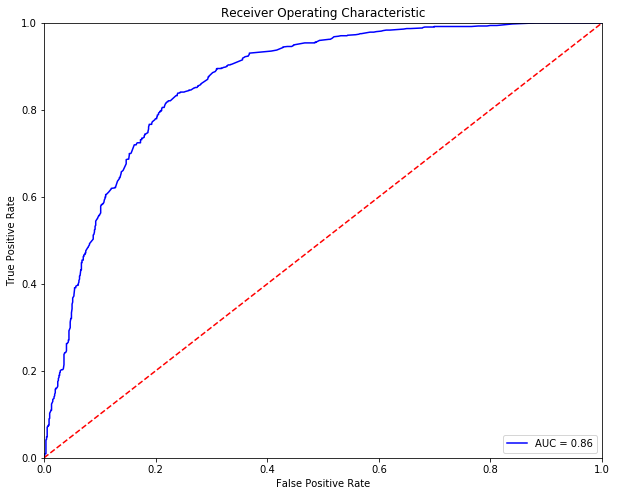

Optimal Threshold is 0.5047097757749248
Accuracy on test data is: 0.7932416953035509


Predicted  False  True  __all__
Actual                         
False        713   184      897
True         177   672      849
__all__      890   856     1746



GradientBoosting Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.2,deviance,5,0.1,50,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8242513500245459

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1578   435     2013
True         281  1780     2061
__all__     1859  2215     4074

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.790950744558992

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        686   211      897
True         154   695      849
__all__      840   906     1746

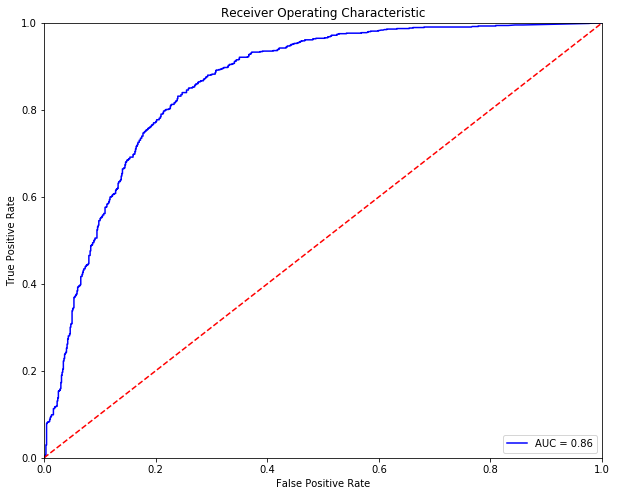

Optimal Threshold is 0.5536229802310828
Accuracy on test data is: 0.7898052691867125


Predicted  False  True  __all__
Actual                         
False        709   188      897
True         179   670      849
__all__      888   858     1746



ExtraTree Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8004418262150221

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1517   496     2013
True         317  1744     2061
__all__     1834  2240     4074

Accuracy of the  Extra Decision Tree  model for test data is: 0.7714776632302406

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        649   248      897
True         151   698      849
__all__      800   946     1746

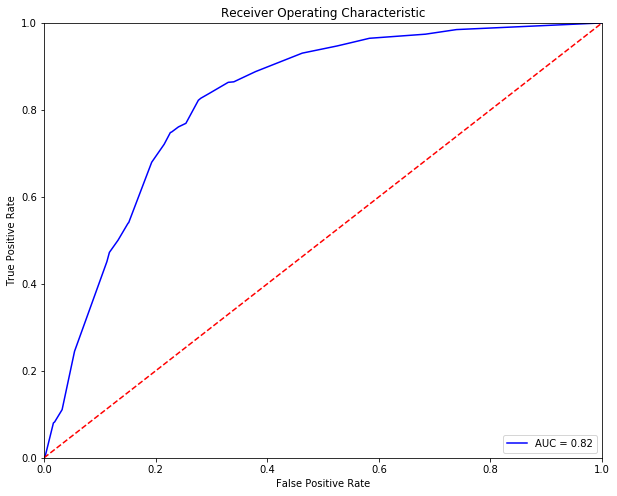

Optimal Threshold is 0.6451612903225806
Accuracy on test data is: 0.7605956471935853


Predicted  False  True  __all__
Actual                         
False        692   205      897
True         213   636      849
__all__      905   841     1746



Bagging Classifier
Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.4,0.3,200,True,0


Accuracy of the  Bagging  model for the training data is: 0.9042709867452136

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1740   273     2013
True         117  1944     2061
__all__     1857  2217     4074

Accuracy of the  Bagging  model for test data is: 0.7943871706758304

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        663   234      897
True         125   724      849
__all__      788   958     1746

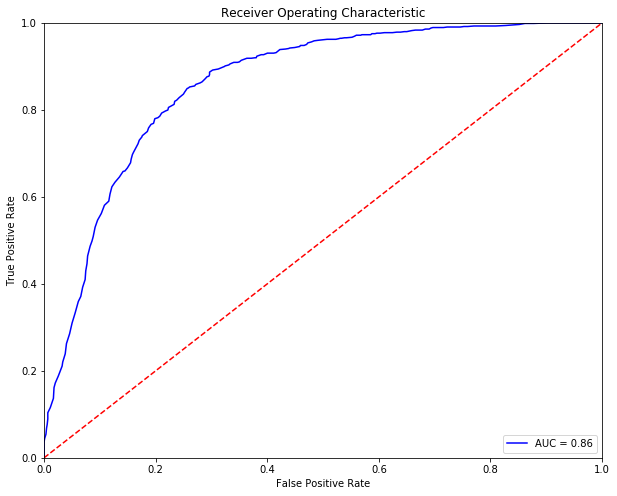

Optimal Threshold is 0.57
Accuracy on test data is: 0.7892325315005727


Predicted  False  True  __all__
Actual                         
False        711   186      897
True         182   667      849
__all__      893   853     1746



Neural Network-1
The accuracy of the model on training data is: 0.8431516936378965


Predicted  False  True  __all__
Actual                         
False       1593   420     2013
True         219  1842     2061
__all__     1812  2262     4074

The accuracy of the model on test data is: 0.7783505154639175


Predicted  False  True  __all__
Actual                         
False        658   239      897
True         148   701      849
__all__      806   940     1746

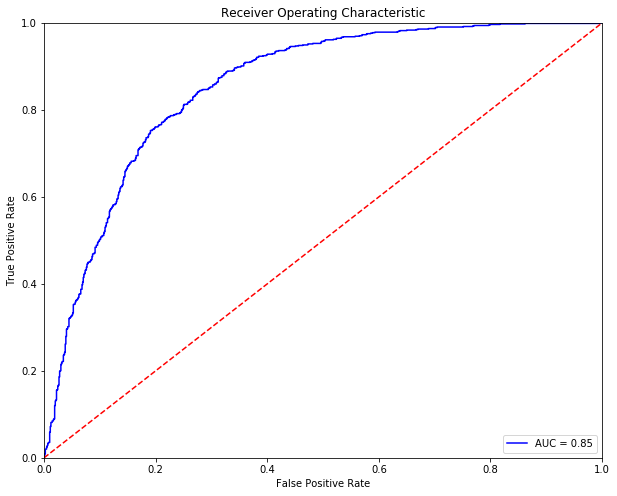

Optimal Threshold is 0.5734111
Accuracy of Logistic Model on training data is: 0.7800687285223368


Predicted  False  True  __all__
Actual                         
False        700   197      897
True         187   662      849
__all__      887   859     1746



Neural Network-2
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.7min finished


The accuracy of the model on training data is: 0.7997054491899853


Predicted  False  True  __all__
Actual                         
False       1525   488     2013
True         328  1733     2061
__all__     1853  2221     4074

The accuracy of the model on test data is: 0.790950744558992


Predicted  False  True  __all__
Actual                         
False        683   214      897
True         151   698      849
__all__      834   912     1746

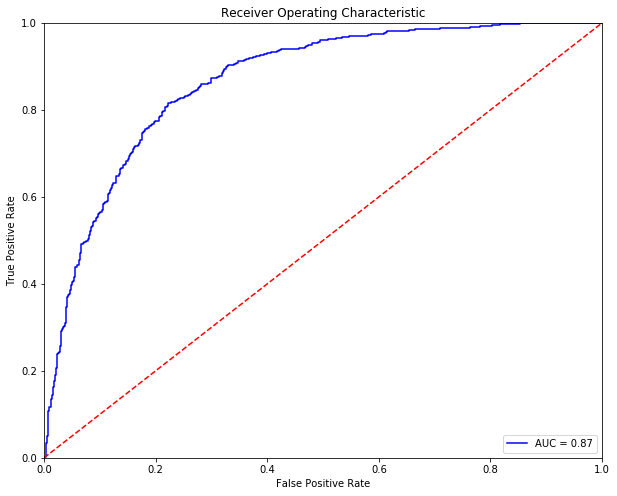

Optimal Threshold is 0.586958
Accuracy on test data is: 0.788659793814433


Predicted  False  True  __all__
Actual                         
False        708   189      897
True         180   669      849
__all__      888   858     1746

In [33]:
feat_imp_10=[None]*4
j=0
for i in range(0,9):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,feat_imp_10[j]=f[i](X_train,Y_train,X_test,Y_test)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_70_50_10_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_70_50_10_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
    table_70_50_10_test_roc.loc[i]=([accuracy, cm.TP,  cm.TN,   cm.FP, cm.FN,  cm.FPR, cm.FNR, threshold,roc_auc])
    print("\n")

In [35]:
table_70_50_10_train['index']=ind_columns
table_70_50_10_test['index']=ind_columns
table_70_50_10_test_roc['index']=ind_columns

table_70_50_10_test.set_index(['index'],drop=True,inplace=True)
table_70_50_10_train.set_index(['index'],drop=True,inplace=True)
table_70_50_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_10_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_10_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,2061.0,2013.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.795533,1630.0,1611.0,402.0,431.0,0.199702,0.209122
RandomForestClassifier,0.799705,1807.0,1451.0,562.0,254.0,0.279185,0.123241
AdaBoostClassifier,0.806333,1783.0,1502.0,511.0,278.0,0.253850,0.134886
GradientBoostingClassifier,0.824251,1780.0,1578.0,435.0,281.0,0.216095,0.136342
ExtraTreeClassifier,0.800442,1744.0,1517.0,496.0,317.0,0.246398,0.153809
BaggingClassifier,0.904271,1944.0,1740.0,273.0,117.0,0.135618,0.056769
Neural Network-1,0.843152,1842.0,1593.0,420.0,219.0,0.208644,0.106259
Neural-Network-2,0.799705,1733.0,1525.0,488.0,328.0,0.242424,0.159146


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.791523,660.0,722.0,175.0,189.0,0.195095,0.222615
LogisticRegression,0.778923,644.0,716.0,181.0,205.0,0.201784,0.241461
RandomForestClassifier,0.787514,723.0,652.0,245.0,126.0,0.273133,0.148410
AdaBoostClassifier,0.798396,712.0,682.0,215.0,137.0,0.239688,0.161366
GradientBoostingClassifier,0.790951,695.0,686.0,211.0,154.0,0.235229,0.181390
ExtraTreeClassifier,0.771478,698.0,649.0,248.0,151.0,0.276477,0.177856
BaggingClassifier,0.794387,724.0,663.0,234.0,125.0,0.260870,0.147232
Neural Network-1,0.778351,701.0,658.0,239.0,148.0,0.266444,0.174323
Neural-Network-2,0.790951,698.0,683.0,214.0,151.0,0.238573,0.177856


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.790378,671.0,709.0,188.0,178.0,0.209588,0.209658,0.468444,0.860204
LogisticRegression,0.779496,661.0,700.0,197.0,188.0,0.219621,0.221437,0.459538,0.863442
RandomForestClassifier,0.784078,655.0,714.0,183.0,194.0,0.204013,0.228504,0.551147,0.813758
AdaBoostClassifier,0.793242,672.0,713.0,184.0,177.0,0.205128,0.208481,0.504710,0.864689
GradientBoostingClassifier,0.789805,670.0,709.0,188.0,179.0,0.209588,0.210836,0.553623,0.861723
ExtraTreeClassifier,0.760596,636.0,692.0,205.0,213.0,0.228540,0.250883,0.645161,0.822393
BaggingClassifier,0.789233,667.0,711.0,186.0,182.0,0.207358,0.214370,0.570000,0.861174
Neural Network-1,0.780069,662.0,700.0,197.0,187.0,0.219621,0.220259,0.573411,0.853039
Neural-Network-2,0.788660,669.0,708.0,189.0,180.0,0.210702,0.212014,0.586958,0.865426


#### Random State 20

In [36]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('Feature_Vector_50_50_12_24_random_state_20.csv',index_col='User')


print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
# # Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(5))
Y=Y.values

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)


## Table to store training and test measures
table_70_50_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_50_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


1    2910
0    2910
Name: Target, dtype: int64

,SP,DP,NAPP,SIP,DIP,NREC,PAR,PAS,LEN,BYS,BYR,0000,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300
User,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ba8eb5d1a8053b0997a90bea829c349d48200b46c815cec429a3f1a997c5ba98,994,23,34,106,305,1011,280.252226,164.641939,83.002967,13987.476756,359758.589515,0,0,0,0,0,0,0,0,1,2,58,80,103,68,62,111,155,226,100,12,15,6,8,4
f5448947a29087e5c7c74bcf1ef14257aaa6bad4990d3e9e976b79fa3511fa48,38,6,6,6,15,38,12.368421,10.394737,48.078947,1728.315789,9966.815789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,15,13,0,0,0,0,0,0,0


1 -> Infected
0 -> Uninfected


User
ba8eb5d1a8053b0997a90bea829c349d48200b46c815cec429a3f1a997c5ba98    0
f5448947a29087e5c7c74bcf1ef14257aaa6bad4990d3e9e976b79fa3511fa48    0
a70d401cfd6804c5711ae7620658b6be8b25483f999cb8bf73e44e011f877dd9    1
22730c54b8e7377fdfa932bf6b6c14741966f73ac8cc7d945fae9264c808afbb    0
47d304146c958a1134c7c928152e25972e4b8e660576183ae7dbca7d7db049db    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.9376584264360198
The train/test split ratio is 70:30


K-Nearest Neighbors
Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,euclidean,30,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2065     0     2065
True           0  2009     2009
__all__     2065  2009     4074

Accuracy of the  KNN  model for test data is: 0.7966781214203894

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        682   163      845
True         192   709      901
__all__      874   872     1746

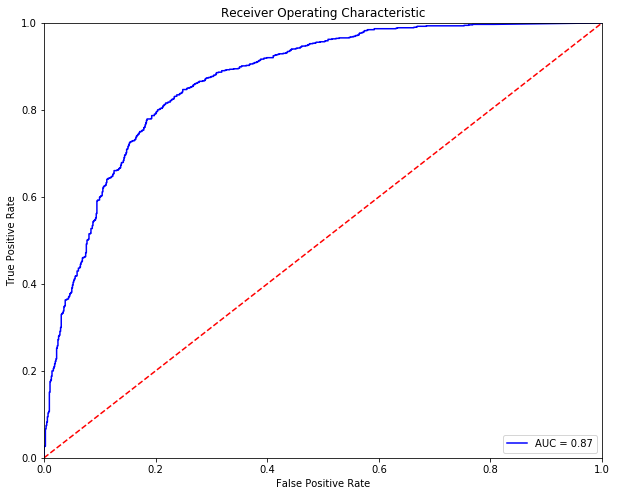

Optimal Threshold is 0.479222235503241
Accuracy on test data is: 0.7972508591065293


Predicted  False  True  __all__
Actual                         
False        674   171      845
True         183   718      901
__all__      857   889     1746



Logistic Regression
Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,100,multinomial,l2,sag,1e-05


Accuracy of the  Logistic  model for the training data is: 0.7881688757977418

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1653   412     2065
True         451  1558     2009
__all__     2104  1970     4074

Accuracy of the  Logistic  model for test data is: 0.7875143184421535

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        696   149      845
True         222   679      901
__all__      918   828     1746

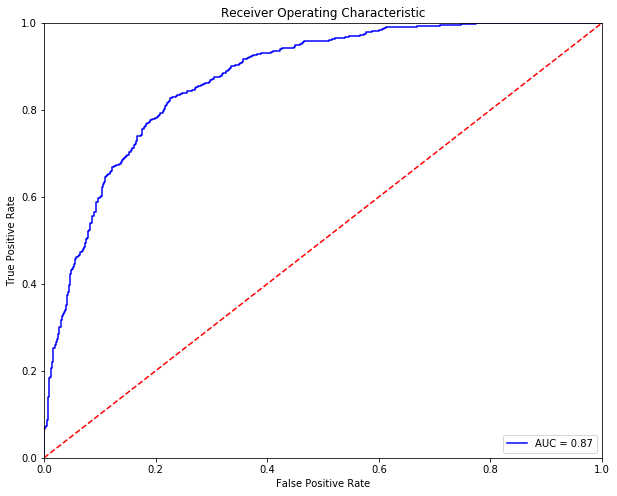

Optimal Threshold is 0.4684476402975801
Accuracy on test data is: 0.7920962199312714


Predicted  False  True  __all__
Actual                         
False        670   175      845
True         188   713      901
__all__      858   888     1746



RandomForest Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7906234658811978

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1491   574     2065
True         279  1730     2009
__all__     1770  2304     4074

Accuracy of the  Random Forest Trees  model for test data is: 0.8012600229095075

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        643   202      845
True         145   756      901
__all__      788   958     1746

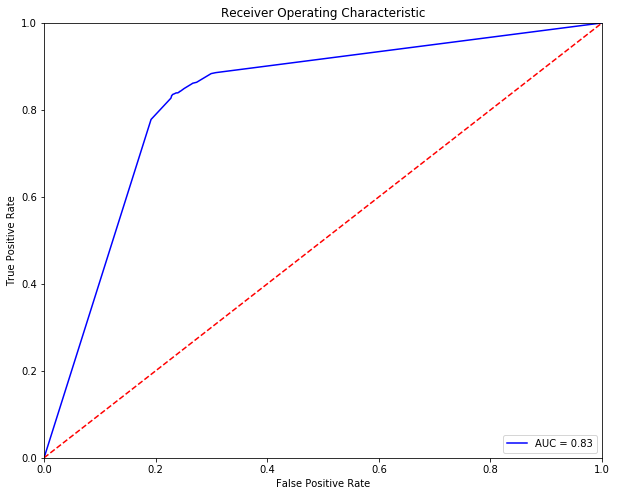

Optimal Threshold is 0.5474566049585589
Accuracy on test data is: 0.48396334478808706


Predicted   0.0  1.0  __all__
Actual                       
0.0         845    0      845
1.0         901    0      901
__all__    1746    0     1746

845
0
0
845
901
0
0
901
1.0
0.0
0.0
1.0


Adaoost Classifier
Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME.R,0.5,50,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.7960235640648011

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1534   531     2065
True         300  1709     2009
__all__     1834  2240     4074

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8081328751431844

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        661   184      845
True         151   750      901
__all__      812   934     1746

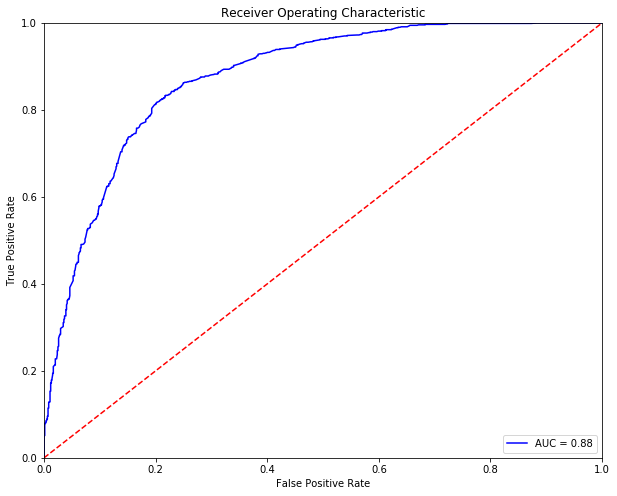

Optimal Threshold is 0.5028522359290377
Accuracy on test data is: 0.8029782359679267


Predicted  False  True  __all__
Actual                         
False        682   163      845
True         181   720      901
__all__      863   883     1746



GradientBoosting Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.05,deviance,10,0.3,150,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8092783505154639

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1602   463     2065
True         314  1695     2009
__all__     1916  2158     4074

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8087056128293242

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        675   170      845
True         164   737      901
__all__      839   907     1746

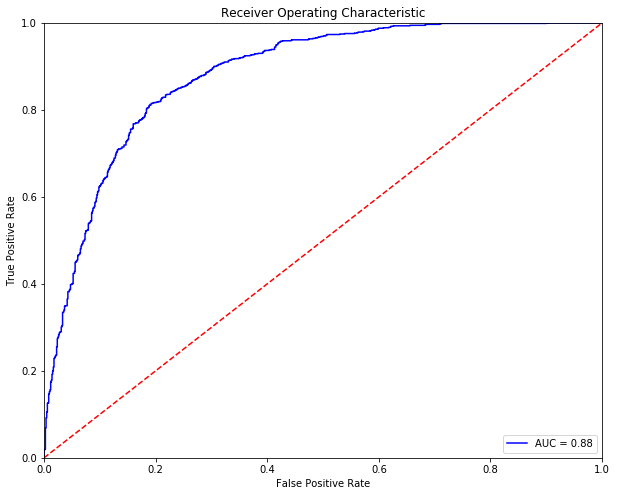

Optimal Threshold is 0.5215079044266054
Accuracy on test data is: 0.8109965635738832


Predicted  False  True  __all__
Actual                         
False        686   159      845
True         171   730      901
__all__      857   889     1746



ExtraTree Classifier
Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8033873343151694

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1577   488     2065
True         313  1696     2009
__all__     1890  2184     4074

Accuracy of the  Extra Decision Tree  model for test data is: 0.7920962199312714

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        651   194      845
True         169   732      901
__all__      820   926     1746

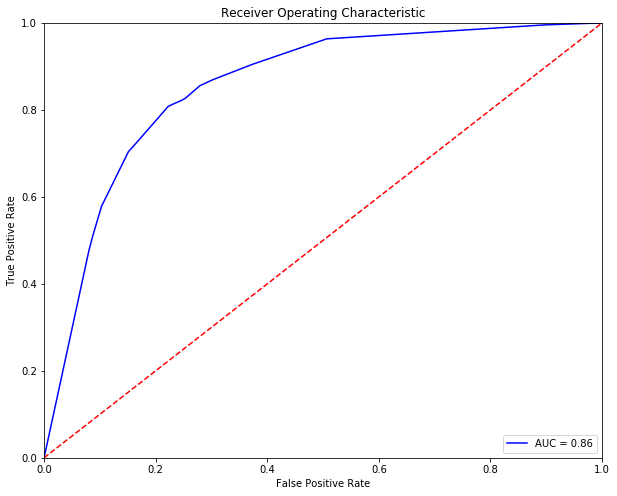

Optimal Threshold is 0.6071428571428571
Accuracy on test data is: 0.7754868270332188


Predicted  False  True  __all__
Actual                         
False        712   133      845
True         259   642      901
__all__      971   775     1746



Bagging Classifier
Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.6,300,True,0


Accuracy of the  Bagging  model for the training data is: 0.9943544428080511

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2063     2     2065
True          21  1988     2009
__all__     2084  1990     4074

Accuracy of the  Bagging  model for test data is: 0.7961053837342497

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        634   211      845
True         145   756      901
__all__      779   967     1746

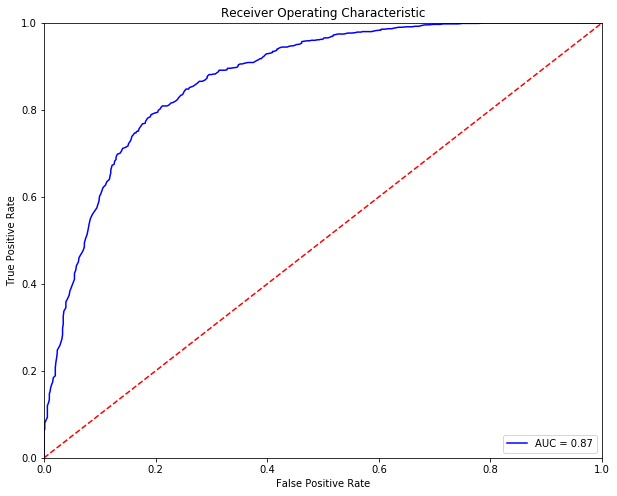

Optimal Threshold is 0.5566666666666666
Accuracy on test data is: 0.7972508591065293


Predicted  False  True  __all__
Actual                         
False        678   167      845
True         187   714      901
__all__      865   881     1746



Neural Network-1
The accuracy of the model on training data is: 0.8394698084834515


Predicted  False  True  __all__
Actual                         
False       1686   379     2065
True         275  1734     2009
__all__     1961  2113     4074

The accuracy of the model on test data is: 0.7961053837342497


Predicted  False  True  __all__
Actual                         
False        674   171      845
True         185   716      901
__all__      859   887     1746

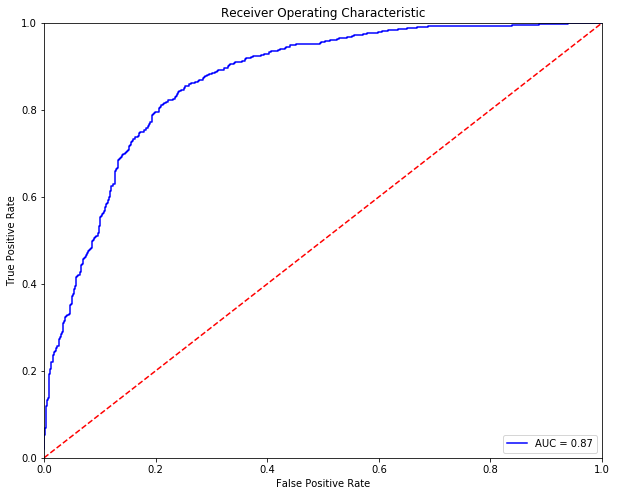

Optimal Threshold is 0.4930306
Accuracy of Logistic Model on training data is: 0.7949599083619702


Predicted  False  True  __all__
Actual                         
False        672   173      845
True         185   716      901
__all__      857   889     1746



Neural Network-2
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.9min finished


The accuracy of the model on training data is: 0.7997054491899853


Predicted  False  True  __all__
Actual                         
False       1581   484     2065
True         332  1677     2009
__all__     1913  2161     4074

The accuracy of the model on test data is: 0.7995418098510882


Predicted  False  True  __all__
Actual                         
False        665   180      845
True         170   731      901
__all__      835   911     1746

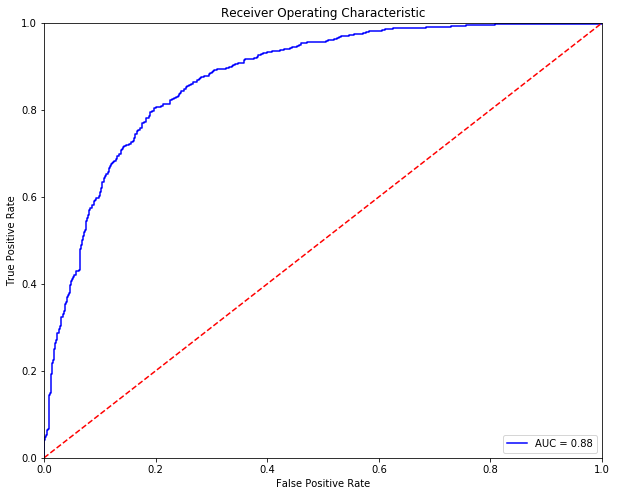

Optimal Threshold is 0.53623056
Accuracy on test data is: 0.8029782359679267


Predicted  False  True  __all__
Actual                         
False        679   166      845
True         178   723      901
__all__      857   889     1746

In [37]:
feat_imp_20=[None]*4
j=0
for i in range(0,9):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc,feat_imp_20[j]=f[i](X_train,Y_train,X_test,Y_test)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,cm,accuracy,threshold,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_70_50_20_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_70_50_20_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
    table_70_50_20_test_roc.loc[i]=([accuracy, cm.TP,  cm.TN,   cm.FP, cm.FN,  cm.FPR, cm.FNR, threshold,roc_auc])
    print("\n")

In [39]:
table_70_50_20_train['index']=ind_columns
table_70_50_20_test['index']=ind_columns
table_70_50_20_test_roc['index']=ind_columns

table_70_50_20_test.set_index(['index'],drop=True,inplace=True)
table_70_50_20_train.set_index(['index'],drop=True,inplace=True)
table_70_50_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_50_20_train)

print("Comparision Table for Test Accuracies:")
display(table_70_50_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_20_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,2009.0,2065.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.788169,1558.0,1653.0,412.0,451.0,0.199516,0.224490
RandomForestClassifier,0.790623,1730.0,1491.0,574.0,279.0,0.277966,0.138875
AdaBoostClassifier,0.796024,1709.0,1534.0,531.0,300.0,0.257143,0.149328
GradientBoostingClassifier,0.809278,1695.0,1602.0,463.0,314.0,0.224213,0.156297
ExtraTreeClassifier,0.803387,1696.0,1577.0,488.0,313.0,0.236320,0.155799
BaggingClassifier,0.994354,1988.0,2063.0,2.0,21.0,0.000969,0.010453
Neural Network-1,0.839470,1734.0,1686.0,379.0,275.0,0.183535,0.136884
Neural-Network-2,0.799705,1677.0,1581.0,484.0,332.0,0.234383,0.165256


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.796678,709.0,682.0,163.0,192.0,0.192899,0.213097
LogisticRegression,0.787514,679.0,696.0,149.0,222.0,0.176331,0.246393
RandomForestClassifier,0.801260,756.0,643.0,202.0,145.0,0.239053,0.160932
AdaBoostClassifier,0.808133,750.0,661.0,184.0,151.0,0.217751,0.167592
GradientBoostingClassifier,0.808706,737.0,675.0,170.0,164.0,0.201183,0.182020
ExtraTreeClassifier,0.792096,732.0,651.0,194.0,169.0,0.229586,0.187569
BaggingClassifier,0.796105,756.0,634.0,211.0,145.0,0.249704,0.160932
Neural Network-1,0.796105,716.0,674.0,171.0,185.0,0.202367,0.205327
Neural-Network-2,0.799542,731.0,665.0,180.0,170.0,0.213018,0.188679


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.797251,718.000000,674.000000,171.000000,183.000000,0.202367,0.203108,0.479222,0.870209
LogisticRegression,0.792096,713.000000,670.000000,175.000000,188.000000,0.207101,0.208657,0.468448,0.873282
RandomForestClassifier,0.483963,408.949026,436.050974,436.050974,464.949026,0.483963,0.516037,0.547457,0.825033
AdaBoostClassifier,0.802978,720.000000,682.000000,163.000000,181.000000,0.192899,0.200888,0.502852,0.875357
GradientBoostingClassifier,0.810997,730.000000,686.000000,159.000000,171.000000,0.188166,0.189789,0.521508,0.881479
ExtraTreeClassifier,0.775487,642.000000,712.000000,133.000000,259.000000,0.157396,0.287458,0.607143,0.855426
BaggingClassifier,0.797251,714.000000,678.000000,167.000000,187.000000,0.197633,0.207547,0.556667,0.874428
Neural Network-1,0.794960,716.000000,672.000000,173.000000,185.000000,0.204734,0.205327,0.493031,0.868581
Neural-Network-2,0.802978,723.000000,679.000000,166.000000,178.000000,0.196450,0.197558,0.536231,0.875057


In [40]:
table_70_50_train_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_70_50_test_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_70_50_test_roc_avg=pd.DataFrame(columns=['accuracy','FPR','FNR','auc'])

table_70_50_train_avg['accuracy']=(table_70_50_train['accuracy']+table_70_50_10_train['accuracy']+table_70_50_20_train['accuracy'])/3.0
table_70_50_train_avg['FPR']=(table_70_50_train['FPR']+table_70_50_10_train['FPR']+table_70_50_20_train['FPR'])/3.0
table_70_50_train_avg['FNR']=(table_70_50_train['FNR']+table_70_50_10_train['FNR']+table_70_50_20_train['FNR'])/3.0

table_70_50_test_avg['accuracy']=(table_70_50_test['accuracy']+table_70_50_10_test['accuracy']+table_70_50_20_test['accuracy'])/3.0
table_70_50_test_avg['FPR']=(table_70_50_test['FPR']+table_70_50_10_test['FPR']+table_70_50_20_test['FPR'])/3.0
table_70_50_test_avg['FNR']=(table_70_50_test['FNR']+table_70_50_10_test['FNR']+table_70_50_20_test['FNR'])/3.0

table_70_50_test_roc_avg['accuracy']=(table_70_50_test_roc['accuracy']+table_70_50_10_test_roc['accuracy']+table_70_50_20_test_roc['accuracy'])/3.0
table_70_50_test_roc_avg['FPR']=(table_70_50_test_roc['FPR']+table_70_50_10_test_roc['FPR']+table_70_50_20_test_roc['FPR'])/3.0
table_70_50_test_roc_avg['FNR']=(table_70_50_test_roc['FNR']+table_70_50_10_test_roc['FNR']+table_70_50_20_test_roc['FNR'])/3.0
table_70_50_test_roc_avg['auc']=(table_70_50_test_roc['auc']+table_70_50_10_test_roc['auc']+table_70_50_20_test_roc['auc'])/3.0


print("-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------")
print("Comparision Table for Training Accuracies:")
display(table_70_50_train_avg)

print("Comparision Table for Test Accuracies:")
display(table_70_50_test_avg)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_50_test_roc_avg)

feat_imp_80_50=list(map(sum, zip(feat_imp,feat_imp_10,feat_imp_20)))
print("Average feature imortance for the 3 random sets:")
feat_impt_plot(sum(feat_imp_80_50)/12)

-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------
Comparision Table for Training Accuracies:


,accuracy,FPR,FNR
index,,,
KNeighborsClassifier,1.000000,0.000000,0.000000
LogisticRegression,0.788251,0.204572,0.218991
RandomForestClassifier,0.793324,0.281049,0.132501
AdaBoostClassifier,0.801096,0.250541,0.147361
GradientBoostingClassifier,0.815333,0.221063,0.148377
ExtraTreeClassifier,0.800442,0.241116,0.158106
BaggingClassifier,0.963590,0.047337,0.025828
Neural Network-1,0.842988,0.201568,0.112817
Neural-Network-2,0.798315,0.239310,0.164178


Comparision Table for Test Accuracies:


,accuracy,FPR,FNR
index,,,
KNeighborsClassifier,0.799351,0.186021,0.215453
LogisticRegression,0.786751,0.191420,0.234763
RandomForestClassifier,0.796296,0.260676,0.145938
AdaBoostClassifier,0.801833,0.232979,0.162893
GradientBoostingClassifier,0.802405,0.221812,0.172834
ExtraTreeClassifier,0.782169,0.253722,0.181222
BaggingClassifier,0.796869,0.251446,0.154419
Neural Network-1,0.782360,0.251130,0.182877
Neural-Network-2,0.799160,0.226872,0.174262


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,FPR,FNR,auc
index,,,,
KNeighborsClassifier,0.799542,0.200054,0.200860,0.867718
LogisticRegression,0.789423,0.209890,0.211266,0.868627
RandomForestClassifier,0.688813,0.289416,0.322640,0.826769
AdaBoostClassifier,0.795533,0.201081,0.207830,0.867868
GradientBoostingClassifier,0.803742,0.195699,0.196813,0.872686
ExtraTreeClassifier,0.766323,0.197806,0.268568,0.838053
BaggingClassifier,0.799160,0.196599,0.205068,0.868658
Neural Network-1,0.781596,0.218171,0.218637,0.856633
Neural-Network-2,0.799351,0.200721,0.200567,0.870376


Average feature imortance for the 3 random sets:


In [2]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')